# Main Analysis of Truck Data
This notebook contains functions to graph SPL and its correlation to truck sounds (as determined by clustering).

Import statements

In [19]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import PolynomialFeatures
import datetime 
from datetime import timedelta
import pytz
from pytz import timezone
import tarfile
from numpy import load
import os
from sklearn.manifold import TSNE
import h5py
from sklearn.decomposition import PCA as sklearnPCA
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn import datasets
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import DBSCAN
from sklearn.cluster import Birch
import scipy as sp
from scipy import spatial
from scipy import stats
import pylab
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import librosa
from scipy import signal
from scipy import ndimage
import matplotlib.dates as md
import sys

Loading the hdf5 files

In [20]:
h5 = h5py.File('sound_data_improved.hdf5', 'r')

In [21]:
d = h5['sound_data']

# Creating subsample of 10000 points from all four sensors

In [22]:
sample_nums = np.random.choice(range(d.shape[0]), 10000, replace = False)

In [23]:
index = np.zeros(d.shape[0]).astype('bool')
index[sample_nums] = True

# Reading and graphing data from one sensor

Reading June data from one of the sensors

In [24]:
df = pd.read_csv("sonycnode-b827ebc178d2.sonyc.csv", skiprows = 2, low_memory = False)
df.head()

,timestamp,dBAS
0,1.559362e+09,63.53
1,1.559362e+09,63.73
2,1.559362e+09,64.94
3,1.559362e+09,63.09
4,1.559362e+09,61.66


Creating two numpy array with the timestamps for June and the corresponding SPL values for June

In [25]:
time_arr = np.empty(df.shape[0], dtype = datetime.datetime)
timestamp_arr = df['timestamp'].values
dBAS_arr = df['dBAS'].values

A function to convert the UNIX timestamps to datetime objects for easier interpretation 

In [26]:
def convert_timestamps(sensor_timestamp):
    """
    Converts a float timestamp to a datetime object.
    
    Parameters
    ----------
    sensor_timestamp : float
        A timestamp in float form.
        
    Returns
    -------
    dt : datetime object
       Datetime object corresponding to the same time as the float timestamp.
    """
    j = sensor_timestamp
    dt = datetime.datetime.utcfromtimestamp(j)
    dt = pytz.UTC.localize(dt)
    dt = dt.astimezone(pytz.timezone('US/Eastern'))
    return dt

Converting the UNIX timestamps to datetime format using above function

In [27]:
time_arr = [convert_timestamps(x) for x in timestamp_arr]

Creating a new dataframe with timestamps in datetime format

In [28]:
time_df = df
time_df['timestamp'] = time_arr
time_df.tail()

,timestamp,dBAS
2589895,2019-07-01 00:00:38.810000-04:00,66.04
2589896,2019-07-01 00:00:39.810000-04:00,69.75
2589897,2019-07-01 00:00:40.810000-04:00,68.68
2589898,2019-07-01 00:00:41.810000-04:00,73.17
2589899,2019-07-01 00:00:42.810000-04:00,77.04


# Clustering on 45 dimensions

Running PCA on the embeddings in order to reduce dimensionality to 45

In [30]:
pca_45 = sklearnPCA(45)
projected_45 = pca_45.fit_transform(d['feature_vector'])

Function to get a boolean mask to filter data to only get data from a certain sensor

In [31]:
def get_sensor_mask(sensor_name, target_arr):
    """
    Returns a mask to apply on an array of data from different sensors. The mask filters out the data from one sensor.
    
    Parameters
    ----------
    sensor_name : String
        The name of the sensor to retrieve the data for, should take the form of b'sonycnode-[name].sonyc'
    
    target_arr : array of Strings
        Array containing the names of all the sensors.
        
    Returns
    -------
    sensor_mask : boolean array
        A boolean array of the same shape as target_arr, with True values corresponding to the indices containing the
        sensor_name.
    """
    sensor_mask = (target_arr == sensor_name)
    return sensor_mask

Function to get a boolean mask to filter data to only get data between two times

In [32]:
def get_time_mask(beginning, end, time_arr):
    """
    Returns a boolean mask to apply to a datetime array, with the goal of returning times between a beginning and 
    end time, including the beginning time but excluding the end time. 
    
    Parameters
    ----------
    beginning : datetime.datetime
        The beginning time to use for the mask.
        
    end : datetime.datetime
        The end time to use for the mask.
        
    time_arr : np array
        A numpy array of naive datetime objects. The mask will be applied to this array.
    """
    interval_mask = (time_arr >= beginning) & (time_arr < end)
    return interval_mask

Function to get cluter assignments for each embedding

In [33]:
def get_cluster_assignments(num_clusters, sensor_transformed, fit_arr):
    """
    Returns an array containing the number of each cluster each data point in sensor_transformed is assigned to.
    Clustering is performed using MiniBatchKMeans.
    
    Parameters
    ----------
    num_clusters : int
        The number of clusters to group sensor_transformed into.
        
    sensor_transformed : array of floats
        45-dimensional array of feature vectors from one sensor 
        
    fit_arr : array of floats
        45-dimensional array of feature vectors from all sensors
    """
    mbk = MiniBatchKMeans(n_clusters=num_clusters, random_state=0)
    mbk.fit(fit_arr)
    cluster_indices = mbk.predict(sensor_transformed)
    return cluster_indices

Function to return the number of hours since the beginning of a month from a timestamp

In [34]:
def convert_to_hour(sensor_timestamp):
    """
    Returns the number of hours since the beginning of the month of a timestamp in Unix format. For example, 
    if the timestamp converts to 9:00 am on June 2nd, 57 (e.g. 48 + 9) would be returned.
    
    Parameters
    ----------
    sensor_timestamp : float
        A Unix timestamp.
        
    total_hour : int
        The number of hours since the beginning of the month of the recording date. 
    """
    j = sensor_timestamp[i]
    dt = datetime.datetime.utcfromtimestamp(j)
    dt = pytz.UTC.localize(dt)
    day = dt.astimezone(pytz.timezone('US/Eastern')).day
    hour = dt.astimezone(pytz.timezone('US/Eastern')).hour
    total_hour = 24*(day-1) + hour
    return total_hour

In [74]:
def get_y_and_bins(num_clusters, sensor_transformed, fit_arr, sensor_timestamps_dt, default_bins, clusters_plot_arr):
    
    test = get_cluster_assignments(num_clusters, sensor_transformed, fit_arr)

    cluster_mask = np.nonzero(test==clusters_plot_arr[0]) #boolean mask for specific cluster number
        
    #Makes array of all timestamps where cluster assignment occurred
    timestamp_arr = np.asarray(sensor_timestamps_dt)[cluster_mask]
        
    #Get y values, bins
    y, bins, _ = plt.hist(timestamp_arr, bins=default_bins)
    
    return y, bins

Function to plot a histogram of the frequency of cluster assignments over time.

In [35]:
def plot_clusters(num_clusters, sensor_transformed, fit_arr, sensor_timestamps_dt, spl_time, spl_dBAS_mean, \
                  spl_dBAS_max, spl_dBAS_median, num_bins, clusters_plot_arr):
    """
    Plots a histogram of the frequency of cluster assignments over time for one sensor.
    
    Parameters
    ----------
    num_clusters : int
        The number of clusters to assign the data to.
        
    sensor_transformed : 45-dimensional array of floats
        An array taken from projected_45 with only the feature vectors corresponding to one sensor.
        
    fit_arr : array of floats
        45-dimensional array of feature vectors from all sensors
        
    sensor_timestamps_dt : datetime array
        Numpy array with dtype=datetime.datetime, containing day values for each data point gathered for a specified
        sensor.
        
    spl_time : datetime array
        Array of datetime objects corresponding to the SPL values.
        
    spl_dBAS_mean : array of floats
        Array of SPL values corresponding to spl_time, averaged over each minute.
        
    spl_dBAS_max : array of floats
        Array of SPL values corresponding to spl_time, consisting of the maximum value from each minute.
        
    spl_dBAS_median : array of floats
        Array of SPL values corresponding to spl_time, consisting of the median value from each minute.
    
    num_bins : int
        The number of bins to group the cluster frequency into.
        
    bin_arr : array of floats
        Array of bin edges to group the cluster frequency into.
        
    clusters_plot_arr : arr of ints within the range(0, num_clusters)
        The indices of the clusters to plot.
    """
    
    #Setting the figure size, layout
    fig = plt.figure(figsize=(15,100), dpi=60)
    subplot_idx = 1
    y_vals = [] #array of all y values, used to get ylim for graph

    test = get_cluster_assignments(num_clusters, sensor_transformed, fit_arr)

    for cluster_num in clusters_plot_arr:
        cluster_mask = np.nonzero(test==cluster_num) #boolean mask for specific cluster number
        
        #If there are no instances of this cluster in the cluster assignments, don't graph
        if(np.sum(cluster_mask) == 0):
            continue
        
        
        #Makes array of all timestamps where cluster assignment occurred
        timestamp_arr = np.asarray(sensor_timestamps_dt)[cluster_mask]
        
        ax1 = fig.add_subplot(num_clusters, 1, subplot_idx)  
        color = 'tab:red'
        ax1.set_xlabel('time')
        ax1.set_ylabel('cluster ' + str(cluster_num), color=color)
    
        #Get y values, bins
        if(cluster_num == clusters_plot_arr[0]):
            y, bins, _ = ax1.hist(timestamp_arr, bins=num_bins, color=color)

        ax1.hist(timestamp_arr, bins=bins, color=color)
        y_vals.append(y.max())
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        color = 'tab:blue'
        ax2.set_ylabel('dBAS', color=color)  # we already handled the x-label with ax1
        ax2.plot(spl_time, spl_dBAS_mean, color=color)
        ax2.plot(spl_time, spl_dBAS_max, color='black')
        ax2.plot(spl_time, spl_dBAS_median, color='green')
        ax2.tick_params(axis='y', labelcolor=color)

        subplot_idx += 1 
    #     axes = plt.gca()
        ax1.set_ylim([0,max(y_vals)])
    
    plt.tight_layout()
    plt.show()
#     print(total_timestamp_arr)
    return bins

In [86]:
def plot_truck_clusters(num_clusters, sensor_transformed, fit_arr, sensor_timestamps_dt, spl_time, spl_dBAS_mean, \
                  spl_dBAS_max, spl_dBAS_median, y_vals, bin_arr, clusters_plot_arr):
    """
    Plots a histogram of the frequency of cluster assignments over time for one sensor.
    
    Parameters
    ----------
    num_clusters : int
        The number of clusters to assign the data to.
        
    sensor_transformed : 45-dimensional array of floats
        An array taken from projected_45 with only the feature vectors corresponding to one sensor.
        
    fit_arr : array of floats
        45-dimensional array of feature vectors from all sensors
        
    sensor_timestamps_dt : datetime array
        Numpy array with dtype=datetime.datetime, containing day values for each data point gathered for a specified
        sensor.
        
    spl_time : datetime array
        Array of datetime objects corresponding to the SPL values.
        
    spl_dBAS_mean : array of floats
        Array of SPL values corresponding to spl_time, averaged over each minute.
        
    spl_dBAS_max : array of floats
        Array of SPL values corresponding to spl_time, consisting of the maximum value from each minute.
        
    spl_dBAS_median : array of floats
        Array of SPL values corresponding to spl_time, consisting of the median value from each minute.
        
    y_vals : array of floats
        array of y values used to calculate the ylim.
        
    bin_arr : array of floats
        Array of bin edges to group the cluster frequency into.
        
    clusters_plot_arr : arr of ints within the range(0, num_clusters)
        The indices of the clusters to plot.
    """
    test = get_cluster_assignments(num_clusters, sensor_transformed, fit_arr)
    
    total_timestamp_arr = []
    y_maxes = [y_vals.max()] #list of all maxes of y values for each cluster number
    for cluster_num in clusters_plot_arr:
        cluster_mask = np.nonzero(test==cluster_num)
        
        if(np.sum(cluster_mask) == 0):
            continue
            
        timestamp_arr = np.asarray(sensor_timestamps_dt)[cluster_mask]
#         total_timestamp_arr = [np.asarray(sensor_timestamps_dt)[cluster_mask] for timestamp in timestamp_arr]
        for timestamp in timestamp_arr:
            total_timestamp_arr.append(timestamp)
    
#     print(total_timestamp_arr)
    
    fig, ax1 = plt.subplots()  
    color = 'tab:red'
    ax1.set_xlabel('time')
    ax1.set_ylabel('truck clusters', color=color)
        
    y, x, _ = ax1.hist(total_timestamp_arr, bins=bin_arr, color=color)
    y_maxes.append(y.max()) #might need to fix later
    ax1.tick_params(axis='y', labelcolor=color)

#     print(bins)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('dBAS', color=color)  # we already handled the x-label with ax1
    ax2.plot(spl_time, spl_dBAS_mean, color=color)
    ax2.plot(spl_time, spl_dBAS_max, color='black')
    ax2.plot(spl_time, spl_dBAS_median, color='green')
    ax2.tick_params(axis='y', labelcolor=color)

#     axes = plt.gca()
    ax1.set_ylim([0,max(y_maxes)])
    
    fig.set_size_inches(18.5, 10.5)
    fig.tight_layout()
    fig.show()
#     print(total_timestamp_arr)
#     return bins

In [37]:
b827ebc178d2_mask = get_sensor_mask(d['sensor_id'], b'sonycnode-b827ebc178d2.sonyc')
b827ebc178d2_transformed = projected_45[b827ebc178d2_mask]
b827ebc178d2_timestamps = d[b827ebc178d2_mask, 'timestamp']
b827ebc178d2_timestamps_dt = [convert_timestamps(x) for x in b827ebc178d2_timestamps]

In [38]:
np.asarray(b827ebc178d2_timestamps_dt, dtype=datetime.datetime).dtype

dtype('O')

In [39]:
b827ebc178d2_timestamps_dt[1]

datetime.datetime(2019, 6, 1, 0, 0, 17, tzinfo=<DstTzInfo 'US/Eastern' EDT-1 day, 20:00:00 DST>)

# Averaging data

Dataset with one data point every minute

In [45]:
minute_time_arr = np.empty(int(len(time_arr)/60), dtype = datetime.datetime)
minute_dBAS_arr = np.empty(int(len(time_arr)/60))

In [46]:
step = 60
i = 0
count = 0
while i < len(time_arr): 
    minute_time_arr[count] = time_arr[i]
    minute_dBAS_arr[count] = np.average(dBAS_arr[i:i+step])
    i += step
    count += 1

# Taking max of data

In [47]:
minute_dBAS_max = np.empty(int(len(time_arr)/60))

In [48]:
step = 60
i = 0
count = 0
while i < len(time_arr): 
    minute_dBAS_max[count] = np.amax(dBAS_arr[i:i+step])
    i += step
    count += 1

In [49]:
minute_dBAS_max

array([73.88, 73.14, 81.78, ..., 74.38, 75.82, 77.04])

# Taking median of data

In [50]:
minute_dBAS_median = np.empty(int(len(time_arr)/60))

In [51]:
step = 60
i = 0
count = 0
while i < len(time_arr): 
    minute_dBAS_median[count] = np.median(dBAS_arr[i:i+step])
    i += step
    count += 1

In [52]:
minute_dBAS_median

array([61.775, 57.79 , 64.23 , ..., 58.02 , 66.055, 61.44 ])

# Plotting 12 hour intervals for one day

Slicing the SPL data

In [53]:
naive_minute_time_arr = [x.replace(tzinfo=None) for x in minute_time_arr]

Slicing for 8am to 8pm

In [54]:
naive_minute_time_arr_np = np.array(naive_minute_time_arr)
minute_time_arr_am_mask = \
get_time_mask(datetime.datetime(2019, 6, 1, 8), datetime.datetime(2019, 6, 1, 20), naive_minute_time_arr_np)

In [55]:
minute_time_arr_am = minute_time_arr[minute_time_arr_am_mask]
minute_dBAS_arr_am = minute_dBAS_arr[minute_time_arr_am_mask]
minute_dBAS_max_am = minute_dBAS_max[minute_time_arr_am_mask]
minute_dBAS_median_am = minute_dBAS_median[minute_time_arr_am_mask]

Slicing for 8pm to 8am

In [56]:
minute_time_arr_pm_mask = \
get_time_mask(datetime.datetime(2019, 6, 1, 20), datetime.datetime(2019, 6, 2, 8), naive_minute_time_arr_np)

In [57]:
minute_time_arr_pm = minute_time_arr[minute_time_arr_pm_mask]
minute_dBAS_arr_pm = minute_dBAS_arr[minute_time_arr_pm_mask]
minute_dBAS_max_pm = minute_dBAS_max[minute_time_arr_pm_mask]
minute_dBAS_median_pm = minute_dBAS_median[minute_time_arr_pm_mask]

Slicing the feature vectors from 8am to 8pm

In [58]:
naive_b827ebc178d2_timestamps_dt = [x.replace(tzinfo=None) for x in b827ebc178d2_timestamps_dt]

In [59]:
naive_b827ebc178d2_timestamps_dt_np = np.array(naive_b827ebc178d2_timestamps_dt)
am_mask = \
get_time_mask(datetime.datetime(2019, 6, 1, 8), datetime.datetime(2019, 6, 1, 20), naive_b827ebc178d2_timestamps_dt_np)

In [60]:
b827ebc178d2_timestamps_dt_am = np.asarray(b827ebc178d2_timestamps_dt)[am_mask]

Slicing the feature vectors from 8pm to 8am

In [61]:
pm_mask = \
get_time_mask(datetime.datetime(2019, 6, 1, 20), datetime.datetime(2019, 6, 2, 8), naive_b827ebc178d2_timestamps_dt_np)

In [62]:
b827ebc178d2_timestamps_dt_pm = np.asarray(b827ebc178d2_timestamps_dt)[pm_mask]

In [63]:
# plot_clusters(15, b827ebc178d2_transformed[am_mask], projected_45[index], b827ebc178d2_timestamps_dt_am, \
#              minute_time_arr_am, minute_dBAS_arr_am, 12*60)

# Plotting 1 hour intervals

Slicing the SPL data

Slicing for 2pm to 3pm

In [64]:
minute_time_arr_hour_mask = \
get_time_mask(datetime.datetime(2019, 6, 1, 14), datetime.datetime(2019, 6, 1, 15), naive_minute_time_arr_np)

In [65]:
minute_time_arr_hour = minute_time_arr[minute_time_arr_hour_mask]
minute_dBAS_arr_hour = minute_dBAS_arr[minute_time_arr_hour_mask]
minute_dBAS_max_hour = minute_dBAS_max[minute_time_arr_hour_mask]
minute_dBAS_median_hour = minute_dBAS_median[minute_time_arr_hour_mask]

Slicing the feature vectors from 2pm to 3pm

In [66]:
hour_mask = \
get_time_mask(datetime.datetime(2019, 6, 1, 14), datetime.datetime(2019, 6, 1, 15), naive_b827ebc178d2_timestamps_dt_np)

In [67]:
b827ebc178d2_timestamps_dt_hour = np.asarray(b827ebc178d2_timestamps_dt)[hour_mask]

# Plotting truck clusters

Truck clusters (in 64 cluster model) are 5, 10, 11, 18, 20, 37, 42, 57, 63

In [68]:
truck_clusters = [5, 10, 11, 18, 20, 37, 42, 57, 63]

In [69]:
# am_bins = plot_clusters(64, b827ebc178d2_transformed[am_mask], projected_45[index], b827ebc178d2_timestamps_dt_am, \
#              minute_time_arr_am, minute_dBAS_arr_am, minute_dBAS_max_am, minute_dBAS_median_am, \
#               12*60, truck_clusters)

In [70]:
# pm_bins = plot_clusters(64, b827ebc178d2_transformed[pm_mask], projected_45[index], b827ebc178d2_timestamps_dt_pm, \
#              minute_time_arr_pm, minute_dBAS_arr_pm, minute_dBAS_max_pm, minute_dBAS_median_pm, \
#               12*60, truck_clusters)

In [71]:
# hour_bins = plot_clusters(64, b827ebc178d2_transformed[hour_mask], projected_45[index], \
#                           b827ebc178d2_timestamps_dt_hour, minute_time_arr_hour, minute_dBAS_arr_hour, \
#                           minute_dBAS_max_hour, minute_dBAS_median_hour, 60, truck_clusters)

In [72]:
#(df['cluster_id']==27).groupby('minute_of_the_day').sum()

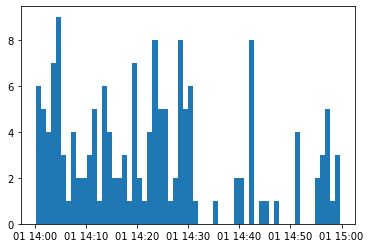

In [76]:
hour_y, hour_bins = get_y_and_bins(64, b827ebc178d2_transformed[hour_mask], projected_45[index], \
                          b827ebc178d2_timestamps_dt_hour, 60, truck_clusters)

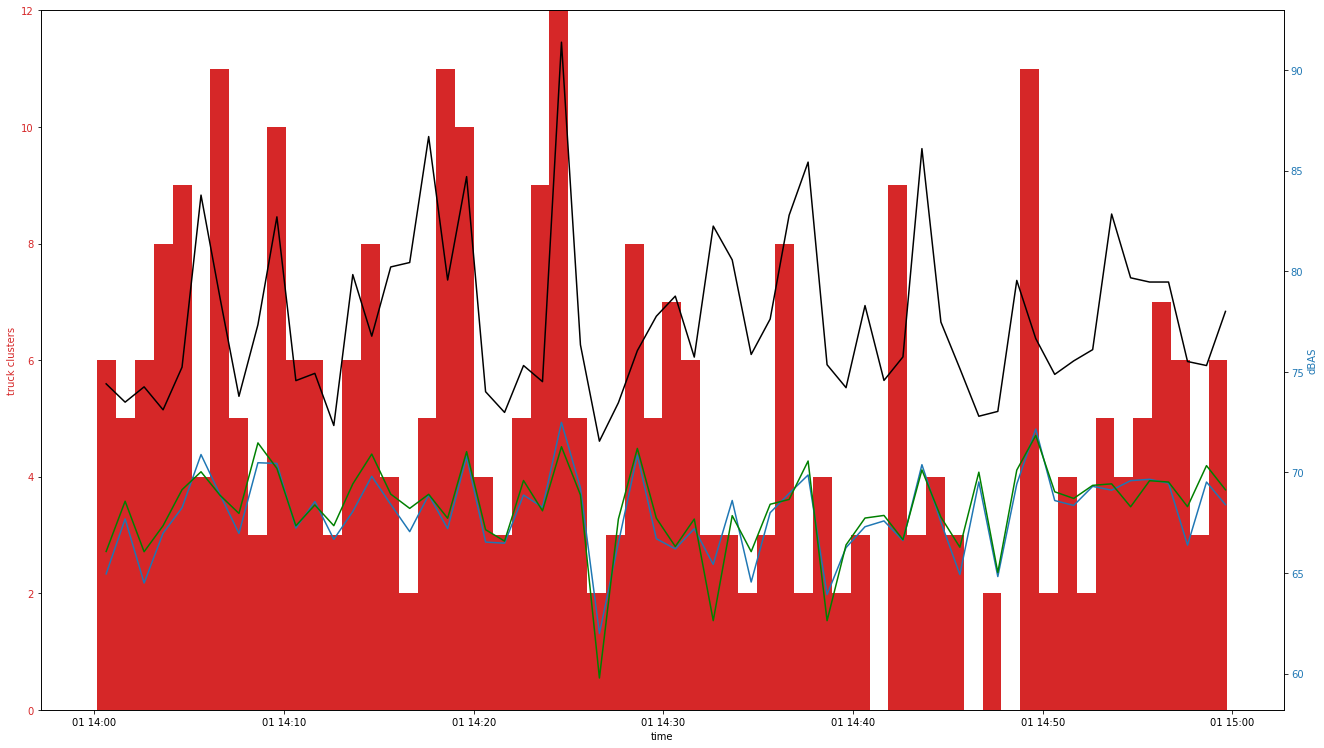

In [87]:
plot_truck_clusters(64, b827ebc178d2_transformed[hour_mask], projected_45[index], \
                          b827ebc178d2_timestamps_dt_hour, minute_time_arr_hour, minute_dBAS_arr_hour, \
                          minute_dBAS_max_hour, minute_dBAS_median_hour, hour_y, hour_bins, truck_clusters)

In [ ]:
plot_truck_clusters(64, b827ebc178d2_transformed[hour_mask], projected_45[index], \
                          b827ebc178d2_timestamps_dt_hour, minute_time_arr_hour, minute_dBAS_arr_hour, \
                          minute_dBAS_max_hour, minute_dBAS_median_hour, hour_bins, truck_clusters)

In [ ]:
# plot_truck_clusters(64, b827ebc178d2_transformed[am_mask], projected_45[index], \
#                           b827ebc178d2_timestamps_dt_am, minute_time_arr_am, minute_dBAS_arr_am, \
#                           minute_dBAS_max_am, minute_dBAS_median_am, am_bins, truck_clusters)

In [ ]:
# plot_truck_clusters(64, b827ebc178d2_transformed[pm_mask], projected_45[index], \
#                           b827ebc178d2_timestamps_dt_pm, minute_time_arr_pm, minute_dBAS_arr_pm, \
#                           minute_dBAS_max_pm, minute_dBAS_median_pm, pm_bins, truck_clusters)

In [ ]:
#TODO: plot median, max of SPL, aggregate cluster info

In [ ]:
len(hour_bins)

# Averaging data over 10 sec

Dataset with one data point every 10 seconds

In [217]:
ten_sec_time_arr = np.empty(int(len(time_arr)/10), dtype = datetime.datetime)
ten_sec_dBAS_arr = np.empty(int(len(time_arr)/10))

In [218]:
step = 10
i = 0
count = 0
while i < len(time_arr): 
    ten_sec_time_arr[count] = time_arr[i]
    ten_sec_dBAS_arr[count] = np.average(dBAS_arr[i:i+step])
    i += step
    count += 1

# Taking max of data

In [220]:
ten_sec_dBAS_max = np.empty(int(len(time_arr)/10))

In [221]:
step = 10
i = 0
count = 0
while i < len(time_arr): 
    ten_sec_dBAS_max[count] = np.amax(dBAS_arr[i:i+step])
    i += step
    count += 1

In [222]:
ten_sec_dBAS_max

array([67.42, 72.63, 62.28, ..., 62.57, 66.96, 77.04])

# Taking median of data

In [223]:
ten_sec_dBAS_median = np.empty(int(len(time_arr)/10))

In [224]:
step = 10
i = 0
count = 0
while i < len(time_arr): 
    ten_sec_dBAS_median[count] = np.median(dBAS_arr[i:i+step])
    i += step
    count += 1

In [225]:
ten_sec_dBAS_median

array([63.63 , 65.575, 58.28 , ..., 57.625, 60.695, 65.255])

# Plotting 12 hour intervals for one day

Slicing the SPL data

In [227]:
naive_ten_sec_time_arr = [x.replace(tzinfo=None) for x in ten_sec_time_arr]

Slicing for 8am to 8pm

In [228]:
naive_ten_sec_time_arr_np = np.array(naive_ten_sec_time_arr)
ten_sec_time_arr_am_mask = \
get_time_mask(datetime.datetime(2019, 6, 1, 8), datetime.datetime(2019, 6, 1, 20), naive_ten_sec_time_arr_np)

In [229]:
ten_sec_time_arr_am = ten_sec_time_arr[ten_sec_time_arr_am_mask]
ten_sec_dBAS_arr_am = ten_sec_dBAS_arr[ten_sec_time_arr_am_mask]
ten_sec_dBAS_max_am = ten_sec_dBAS_max[ten_sec_time_arr_am_mask]
ten_sec_dBAS_median_am = ten_sec_dBAS_median[ten_sec_time_arr_am_mask]

Slicing for 8pm to 8am

In [230]:
ten_sec_time_arr_pm_mask = \
get_time_mask(datetime.datetime(2019, 6, 1, 20), datetime.datetime(2019, 6, 2, 8), naive_ten_sec_time_arr_np)

In [231]:
ten_sec_time_arr_pm = ten_sec_time_arr[ten_sec_time_arr_pm_mask]
ten_sec_dBAS_arr_pm = ten_sec_dBAS_arr[ten_sec_time_arr_pm_mask]
ten_sec_dBAS_max_pm = ten_sec_dBAS_max[ten_sec_time_arr_pm_mask]
ten_sec_dBAS_median_pm = ten_sec_dBAS_median[ten_sec_time_arr_pm_mask]

# Plotting 1 hour intervals

Slicing the SPL data

Slicing for 2pm to 3pm

In [232]:
ten_sec_time_arr_hour_mask = \
get_time_mask(datetime.datetime(2019, 6, 1, 14), datetime.datetime(2019, 6, 1, 15), naive_ten_sec_time_arr_np)

In [233]:
ten_sec_time_arr_hour = ten_sec_time_arr[ten_sec_time_arr_hour_mask]
ten_sec_dBAS_arr_hour = ten_sec_dBAS_arr[ten_sec_time_arr_hour_mask]
ten_sec_dBAS_max_hour = ten_sec_dBAS_max[ten_sec_time_arr_hour_mask]
ten_sec_dBAS_median_hour = ten_sec_dBAS_median[ten_sec_time_arr_hour_mask]

In [266]:
# ten_sec_hour_bins = plot_clusters(64, b827ebc178d2_transformed[hour_mask], projected_45[index], \
#                           b827ebc178d2_timestamps_dt_hour, ten_sec_time_arr_hour, ten_sec_dBAS_arr_hour, \
#                           ten_sec_dBAS_max_hour, ten_sec_dBAS_median_hour, 600, truck_clusters)

In [640]:
# plot_truck_clusters(64, b827ebc178d2_transformed[hour_mask], projected_45[index], \
#                           b827ebc178d2_timestamps_dt_hour, ten_sec_time_arr_hour, ten_sec_dBAS_arr_hour, \
#                           ten_sec_dBAS_max_hour, ten_sec_dBAS_median_hour, ten_sec_hour_bins, truck_clusters)

# Dataframe with timestamps and classification (truck, other, or unknown)

In [472]:
cluster_assignments = get_cluster_assignments(64, b827ebc178d2_transformed[hour_mask], projected_45[index])
seconds_b827ebc178d2_timestamps_dt_hour = [x.replace(microsecond=0) for x in b827ebc178d2_timestamps_dt_hour]

In [475]:
duplicates = set([x for x in seconds_b827ebc178d2_timestamps_dt_hour if \
                  seconds_b827ebc178d2_timestamps_dt_hour.count(x) > 1])

set()

In [476]:
assignments_df = pd.DataFrame(data={'assignment':cluster_assignments}, \
                              index = seconds_b827ebc178d2_timestamps_dt_hour)
assignments_df

,assignment
2019-06-01 14:00:08-04:00,52
2019-06-01 14:00:09-04:00,6
2019-06-01 14:00:10-04:00,6
2019-06-01 14:00:11-04:00,33
2019-06-01 14:00:12-04:00,6
2019-06-01 14:00:13-04:00,33
2019-06-01 14:00:14-04:00,36
2019-06-01 14:00:15-04:00,6
2019-06-01 14:00:16-04:00,48
2019-06-01 14:00:17-04:00,32


In [568]:
complete_hour = pd.date_range(datetime.datetime(2019, 6, 1, 18), datetime.datetime(2019, 6, 1, 19), periods=3601)
seconds_complete_hour = [x.replace(microsecond=0, nanosecond=0) for x in complete_hour]
aware_seconds_complete_hour = [pytz.utc.localize(x) for x in seconds_complete_hour]
tz_seconds_complete_hour = [x.astimezone(pytz.timezone('US/Eastern')) for x in aware_seconds_complete_hour]

In [569]:
len(tz_seconds_complete_hour)

3601

0 is unknown, 1 is truck, 2 is other

In [584]:
complete_assignments_df_hour = assignments_df.reindex(tz_seconds_complete_hour[:3600], axis='index', fill_value = 0)

In [585]:
complete_assignments_df_hour = complete_assignments_df_hour.replace(truck_clusters, 1)
complete_assignments_df_hour = complete_assignments_df_hour.replace(range(2,64), 2)

In [586]:
complete_assignments_df_hour.tail()

,assignment
2019-06-01 14:59:55-04:00,2
2019-06-01 14:59:56-04:00,2
2019-06-01 14:59:57-04:00,2
2019-06-01 14:59:58-04:00,2
2019-06-01 14:59:59-04:00,2


Trying for a complete dataframe

In [593]:
all_cluster_assignments = get_cluster_assignments(64, b827ebc178d2_transformed, projected_45[index])
seconds_b827ebc178d2_timestamps_dt = [x.replace(microsecond=0) for x in b827ebc178d2_timestamps_dt]

In [598]:
assignments_df = pd.DataFrame(data={'assignment':all_cluster_assignments}, \
                              index = seconds_b827ebc178d2_timestamps_dt)
assignments_df.head()

,assignment
2019-06-01 00:00:16-04:00,2
2019-06-01 00:00:17-04:00,63
2019-06-01 00:00:18-04:00,63
2019-06-01 00:00:19-04:00,63
2019-06-01 00:00:20-04:00,63


In [780]:
x1 = pd.DataFrame({'test':np.arange(10)})
x2 = pd.DataFrame({'test':np.arange(10,20)})
x3 = pd.concat([x1, x2])

In [783]:
x3.index.duplicated()

array([False, False, False, False, False, False, False, False, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [800]:
assignments_df.loc[assignments_df[assignments_df.index.duplicated()].index[6]]

,assignment
2019-06-12 02:10:12-04:00,37
2019-06-12 02:10:12-04:00,52


In [719]:
len(assignments_df)

1423048

In [601]:
removed_assignments_df = assignments_df[~assignments_df.index.duplicated()]

In [604]:
len(removed_assignments_df)

1422967

In [605]:
complete = pd.date_range(datetime.datetime(2019, 6, 1, 4), datetime.datetime(2019, 7, 1, 4), periods=3600*24*30)
seconds_complete = [x.replace(microsecond=0, nanosecond=0) for x in complete]
aware_seconds_complete = [pytz.utc.localize(x) for x in seconds_complete]
tz_seconds_complete = [x.astimezone(pytz.timezone('US/Eastern')) for x in aware_seconds_complete]

In [607]:
complete_assignments_df = removed_assignments_df.reindex(tz_seconds_complete, axis='index', fill_value = 0)

In [608]:
complete_assignments_df = complete_assignments_df.replace(truck_clusters, 1)
complete_assignments_df = complete_assignments_df.replace(range(2,64), 2)

In [2456]:
complete_assignments_df.head()

,assignment
2019-06-01 00:00:00-04:00,0
2019-06-01 00:00:01-04:00,0
2019-06-01 00:00:02-04:00,0
2019-06-01 00:00:03-04:00,0
2019-06-01 00:00:04-04:00,0


In [859]:
complete_assignments_df.tail()

,assignment
2019-06-30 23:59:55-04:00,2
2019-06-30 23:59:56-04:00,0
2019-06-30 23:59:57-04:00,0
2019-06-30 23:59:58-04:00,0
2019-07-01 00:00:00-04:00,0


In [610]:
len(complete_assignments_df)

2592000

# SPL dataframe

In [460]:
time_df.head()

,timestamp,dBAS
0,2019-06-01 00:00:42.690000-04:00,63.53
1,2019-06-01 00:00:43.690000-04:00,63.73
2,2019-06-01 00:00:44.690000-04:00,64.94
3,2019-06-01 00:00:45.690000-04:00,63.09
4,2019-06-01 00:00:46.690000-04:00,61.66


In [482]:
naive_time_df = [x.replace(tzinfo=None) for x in time_df['timestamp']]

In [526]:
complete_hour_mask = get_time_mask(datetime.datetime(2019, 6, 1, 14), \
                                   datetime.datetime(2019, 6, 1, 15), np.asarray(naive_time_df))

In [527]:
seconds_complete_hour_timestamp = [x.replace(microsecond=0) for x in time_df['timestamp'][complete_hour_mask]]

In [528]:
dBAS_hour = np.asarray(time_df['dBAS'][complete_hour_mask])

In [529]:
spl_hour_df = pd.DataFrame(data={'dBAS': dBAS_hour}, index=seconds_complete_hour_timestamp)

In [530]:
spl_hour_df.tail()

,dBAS
2019-06-01 14:59:55-04:00,63.58
2019-06-01 14:59:56-04:00,65.32
2019-06-01 14:59:57-04:00,67.63
2019-06-01 14:59:58-04:00,69.10
2019-06-01 14:59:59-04:00,71.14


Complete SPL dataframe

In [611]:
seconds_complete_timestamp = [x.replace(microsecond=0) for x in time_df['timestamp']]

In [612]:
spl_df = pd.DataFrame(data={'dBAS': dBAS_arr}, index=seconds_complete_timestamp)

In [644]:
spl_df.tail()

,dBAS
2019-07-01 00:00:38-04:00,66.04
2019-07-01 00:00:39-04:00,69.75
2019-07-01 00:00:40-04:00,68.68
2019-07-01 00:00:41-04:00,73.17
2019-07-01 00:00:42-04:00,77.04


# Joining dataframes

This dataframe is for the whole month, so if you slice it based on date, it will give you different subsets of information. There is no need to recreate any dataframes.

In [808]:
all_joined_df = spl_df.join(complete_assignments_df)

In [818]:
all_joined_df.loc[pd.isnull(all_joined_df['assignment']), 'assignment'] = 0

In [819]:
all_joined_df.tail(100)

,dBAS,assignment
2019-06-30 23:59:03-04:00,60.25,2.0
2019-06-30 23:59:04-04:00,61.27,2.0
2019-06-30 23:59:05-04:00,60.68,2.0
2019-06-30 23:59:06-04:00,61.39,2.0
2019-06-30 23:59:07-04:00,65.14,1.0
2019-06-30 23:59:08-04:00,68.70,2.0
2019-06-30 23:59:09-04:00,67.40,1.0
2019-06-30 23:59:10-04:00,71.55,2.0
2019-06-30 23:59:11-04:00,72.03,2.0
2019-06-30 23:59:12-04:00,70.59,1.0


In [860]:
all_joined_df_cut = all_joined_df[:-42]

In [1563]:
all_joined_df_cut.head()

,dBAS,assignment
2019-06-01 00:00:42-04:00,63.53,2.0
2019-06-01 00:00:43-04:00,63.73,1.0
2019-06-01 00:00:44-04:00,64.94,1.0
2019-06-01 00:00:45-04:00,63.09,2.0
2019-06-01 00:00:46-04:00,61.66,1.0


In [1565]:
len(all_joined_df_cut) + 42

2589900

In [1287]:
np.sum(np.isnan(all_joined_df_cut))

dBAS          0
assignment    0
dtype: int64

In [704]:
hour_joined_df = complete_assignments_df_hour.join(spl_hour_df)

In [705]:
hour_joined_df.head()

,assignment,dBAS
2019-06-01 14:00:00-04:00,0,58.68
2019-06-01 14:00:01-04:00,0,58.77
2019-06-01 14:00:02-04:00,0,59.14
2019-06-01 14:00:03-04:00,0,57.87
2019-06-01 14:00:04-04:00,0,58.71


In [864]:
am_joined_df = all_joined_df_cut['2019-06-01 08:00:00-04:00':'2019-06-01 20:00:00-04:00']

In [866]:
am_joined_df.tail()

,dBAS,assignment
2019-06-01 19:59:56-04:00,65.82,1.0
2019-06-01 19:59:57-04:00,62.40,2.0
2019-06-01 19:59:58-04:00,63.28,2.0
2019-06-01 19:59:59-04:00,62.96,2.0
2019-06-01 20:00:00-04:00,63.38,0.0


In [665]:
import scipy.signal
import scipy.ndimage

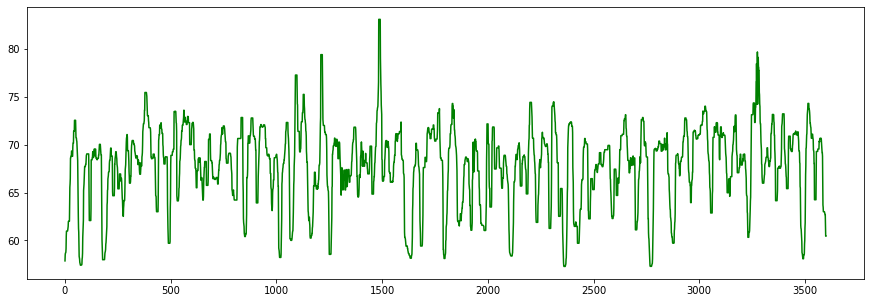

In [671]:
ds_factor = 1
plt.figure(figsize=(15,5))
#plt.plot(hour_joined_df['dBAS'].values[::ds_factor], color='b')
#plt.plot(scipy.signal.medfilt(hour_joined_df['dBAS'].values[::10], 61), color='g')
plt.plot(scipy.signal.medfilt(hour_joined_df['dBAS'].values[::ds_factor], 15), color='g')
#plt.plot(scipy.ndimage.maximum_filter(hour_joined_df['dBAS'].values[::ds_factor], 15), color='r')

# Plotting truck activity differently

In [709]:
truck_hour_df = hour_joined_df.loc[hour_joined_df['assignment']==1]

In [1118]:
test_lib = librosa.util.peak_pick(truck_hour_df['dBAS'], 3, 3, 3, 3, 0, 0)

In [1119]:
test_lib

array([  0,   4,   8,  12,  17,  23,  36,  41,  44,  53,  57,  61,  65,
        68,  74,  86,  95, 104, 111, 116, 130, 136, 141, 145, 152, 158,
       163, 169, 173, 176, 181, 184, 203, 209, 215, 222])

In [1183]:
truck_hour_df.reset_index()['index'].loc[test_lib]

0     2019-06-01 14:00:40-04:00
4     2019-06-01 14:02:19-04:00
8     2019-06-01 14:04:56-04:00
12    2019-06-01 14:06:30-04:00
17    2019-06-01 14:08:47-04:00
23    2019-06-01 14:10:06-04:00
36    2019-06-01 14:15:31-04:00
41    2019-06-01 14:16:47-04:00
44    2019-06-01 14:18:15-04:00
53    2019-06-01 14:20:10-04:00
57    2019-06-01 14:21:07-04:00
61    2019-06-01 14:23:31-04:00
65    2019-06-01 14:25:03-04:00
68    2019-06-01 14:26:24-04:00
74    2019-06-01 14:27:29-04:00
86    2019-06-01 14:31:52-04:00
95    2019-06-01 14:32:53-04:00
104   2019-06-01 14:33:26-04:00
111   2019-06-01 14:34:49-04:00
116   2019-06-01 14:35:29-04:00
130   2019-06-01 14:37:32-04:00
136   2019-06-01 14:38:50-04:00
141   2019-06-01 14:39:51-04:00
145   2019-06-01 14:41:13-04:00
152   2019-06-01 14:44:04-04:00
158   2019-06-01 14:45:24-04:00
163   2019-06-01 14:46:45-04:00
169   2019-06-01 14:48:10-04:00
173   2019-06-01 14:48:48-04:00
176   2019-06-01 14:49:30-04:00
181   2019-06-01 14:50:29-04:00
184   20

In [850]:
hour_joined_df[hour_joined_df.index[0]:hour_joined_df.index[1]]

,assignment,dBAS
2019-06-01 14:00:00-04:00,0,58.68
2019-06-01 14:00:01-04:00,0,58.77


In [1281]:
def plot_truck_clusters_scatter(joined_df, peak_window_size, smoothing_window_size, ds_factor, smoothing):
    """
    Plots the SPL over time with visual cues indicating the presence of trucks over time for one sensor.
    
    Parameters
    ----------
    joined_df : dataframe
        A dataframe containing timestamps, a column for cluster assignments, and dBAS values.
    
    peak_window_size : int
        Parameter for peak picking
        
    ds_factor : int
        Downsample factor for getting the median
    """
    y_vals = []
    joined_df_reset_index = joined_df.reset_index()
#     sliced_trucks_df = sliced_joined_df.loc[sliced_joined_df['assignment']==1]
#     sliced_other_df = sliced_joined_df.loc[sliced_joined_df['assignment']==2]
    
    #maybe make a mask for the max SPL that takes timestamps for peaks, then apply it to truck clusters?
    #Peaks for all SPL values
    window = int((peak_window_size-1)/2)
    spl_peaks = librosa.util.peak_pick(joined_df['dBAS'], window, window, window, window, 3, 0)
#     print('number of spl peaks: ' + str(len(sliced_spl_peaks)))
    spl_peaks_arr = joined_df_reset_index.loc[spl_peaks]
    dBAS_peaks = joined_df['dBAS'][spl_peaks]
    timestamp_peaks = joined_df_reset_index['index'][spl_peaks]
#     sliced_assignment_peaks = sliced_joined_df['assignment'][sliced_spl_peaks]
#     print(sliced_spl_peaks_arr)
    #Peaks for SPL values corresponding to trucks
#     sliced_truck_spl_peaks = librosa.util.peak_pick(sliced_trucks_df['dBAS'], \
#                                                     window, window, window, window, window, 0)
#     print('number of truck peaks: ' + str(len(sliced_truck_spl_peaks)))
#     sliced_truck_spl_peaks = sliced_spl_peaks_arr.loc[sliced_spl_peaks_arr['assignment']==1]
#     print('truck_spl_peaks: ')
#     print(sliced_truck_spl_peaks)
#     sliced_trucks_df_reset_index = sliced_trucks_df.reset_index()
   
    truck_timestamp_peaks = spl_peaks_arr['index'].loc[spl_peaks_arr['assignment']==1]
    print(truck_timestamp_peaks)
    truck_dBAS_peaks = spl_peaks_arr['dBAS'].loc[spl_peaks_arr['assignment']==1]
    print(truck_dBAS_peaks)
    
    
    #Peaks for SPL values corresponding to other clusters
#     sliced_other_spl_peaks = librosa.util.peak_pick(sliced_other_df['dBAS'], \
#                                                     window, window, window, window, window, 0)
    other_dBAS_peaks = spl_peaks_arr.loc[spl_peaks_arr['assignment']==2]['dBAS']
#     print(sliced_other_dBAS_peaks)
#     sliced_other_df_reset_index = sliced_other_df.reset_index()
    other_timestamp_peaks = spl_peaks_arr.loc[spl_peaks_arr['assignment']==2]['index']
    
    fig, ax1 = plt.subplots()  
    color = 'b'
    
    ax1.set_xlabel('time')
    ax1.set_ylabel('SPL', color=color)
        
    #Plot all SPL peaks
#     ax1.scatter(sliced_timestamp_peaks, sliced_dBAS_peaks, color='b', alpha=0.7)
    #Plot dot over max SPL value when that value corresponds to a trucking instance
    ax1.scatter(truck_timestamp_peaks, truck_dBAS_peaks, color='r', s=20)
    ax1.tick_params(axis='y', labelcolor=color)
    
    #Plot SPL peaks corresponding to other clusters
    ax1.scatter(other_timestamp_peaks, other_dBAS_peaks, color='tab:gray', s=20)
#     ax1.plot(sliced_joined_df_reset_index['index'], sliced_joined_df['dBAS'])
    ax1.set_xlim([joined_df_reset_index['index'].iloc[0], joined_df_reset_index['index'].iloc[-1]])
    
    if smoothing == 'median':
        medfit = scipy.signal.medfilt(joined_df['dBAS'].values, smoothing_window_size)[::ds_factor]
        ax1.plot(joined_df.iloc[::ds_factor].reset_index()['index'], medfit, color='g')
        max_y = medfit
    elif smoothing == 'mean':
        mean_filter = scipy.ndimage.convolve(joined_df['dBAS'].values, 
                                             np.ones(smoothing_window_size) / smoothing_window_size)[::ds_factor]
        ax1.plot(joined_df.iloc[::ds_factor].reset_index()['index'], mean_filter, color='g')
        max_y = mean_filter        
    elif smoothing == 'gaussian':
        gaussian_filter = scipy.ndimage.filters.gaussian_filter(joined_df['dBAS'].values, smoothing_window_size)[::ds_factor]
        ax1.plot(joined_df.iloc[::ds_factor].reset_index()['index'], gaussian_filter, color='g')
        max_y = gaussian_filter
    else:
        raise Exception('Unknown smoothing type')
    
    print(len(joined_df.iloc[::ds_factor]))
    #Plot regions corresponding to trucks
    ax1.fill_between(x=joined_df.iloc[::ds_factor].reset_index()['index'], \
                     y1=len(joined_df.iloc[::ds_factor]['dBAS'])*[joined_df['dBAS'].min()], \
                     y2=max_y, \
                     where=joined_df.iloc[::ds_factor].reset_index()['assignment']==1, \
                     color='r', alpha=0.5)
    
    #Plot regions corresponding to other clusters
    ax1.fill_between(x=joined_df.iloc[::ds_factor].reset_index()['index'], \
                     y1=len(joined_df.iloc[::ds_factor]['dBAS'])*[joined_df['dBAS'].min()], \
                     y2=max_y, where=joined_df.iloc[::ds_factor].reset_index()['assignment']==2, \
                     color='tab:gray', alpha=0.5)
    
    ax1.set_ylim(joined_df['dBAS'].min())
    fig.set_size_inches(18.5, 10.5)
    fig.tight_layout()
    fig.show()

In [1282]:
# plot_truck_clusters_scatter(hour_joined_df, hour_joined_df.index[0], hour_joined_df.index[-1], 7, 11, 1, 'gaussian')

In [1283]:
# all_joined_df_cut['2019-06-03 14:00:00-04:00':'2019-06-03 14:30:00-04:00'].iloc[::15].reset_index()['index']

In [1773]:
# plot_truck_clusters_scatter(all_joined_df_cut['2019-06-03 14:00:00-04:00':'2019-06-03 14:30:00-04:00'], \
#                             7, 11, 15, 'mean')

In [2318]:
# plot_truck_clusters_scatter(all_joined_df_cut['2019-06-03 14:40:00-04:00':'2019-06-03 14:50:00-04:00'], \
#                             7, 0.5, 1, 'gaussian')

# Creating matrix of SPL values over each day

Matrix of time and day, containing SPL values for every second of every day (only weekdays)

In [1292]:
spl_complete = spl_df['dBAS']

In [1313]:
beginning_spl_indices = \
pd.date_range(datetime.datetime(2019, 6, 1, 4, 0, 0), datetime.datetime(2019, 6, 1, 4, 0, 42), periods=42)
beginning_spl_indices = [x.replace(microsecond=0, nanosecond=0) for x in beginning_spl_indices]
beginning_spl_indices = [pytz.utc.localize(x) for x in beginning_spl_indices]
beginning_spl_indices = [x.astimezone(pytz.timezone('US/Eastern')) for x in beginning_spl_indices]

In [1317]:
beginning_spl = pd.Series(np.nan, index=beginning_spl_indices)

In [1319]:
spl_complete_2 = pd.concat([beginning_spl, spl_complete])

In [1342]:
spl_complete_month = spl_complete_2[:-43]

In [1345]:
spl_complete_month_weekdays = spl_complete_month[spl_complete_month.index.dayofweek < 5]

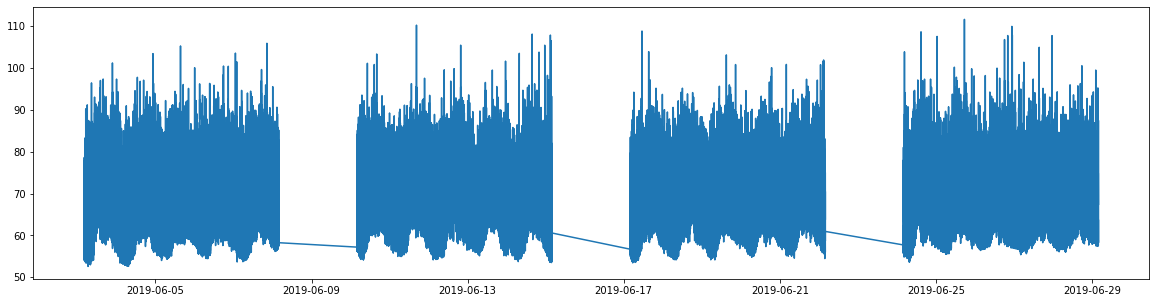

In [1389]:
plt.figure(figsize=(20,5))
plt.plot(spl_complete_month_weekdays)
plt.show()

In [1474]:
spl_complete_month_weekdays.loc['2019-06-03 00:00:00-04:00']

56.99

In [1484]:
spl_complete_month_weekdays = spl_complete_month_weekdays[~spl_complete_month_weekdays.index.duplicated()]

In [2158]:
def get_median(spl_arr):
    all_day_arr = []
    print(np.unique(spl_arr.index.day))
    for day in np.unique(spl_arr.index.day):
        day_arr = [x for x in spl_arr.reset_index()['index'] \
                   if x.day==day]
        all_day_arr.append(day_arr)
        print(str(day) + ': ' + str(len(day_arr)))

    day_time_matrix = np.ndarray((86400,len(all_day_arr)))
    for i,day in enumerate(all_day_arr):
        complete_day_arr = np.zeros(86400)
        for time in day:
            num_secs_since_beginning = 3600*time.hour + 60*time.minute + time.second
            complete_day_arr[num_secs_since_beginning] = \
            spl_arr.loc[time]
#             print(str(time) + str(spl_arr.loc[time]))
        #changes zeros to NaN values for the purposes of getting a median
        complete_day_arr[complete_day_arr<1] = np.nan

        day_time_matrix[:,i] = complete_day_arr
    
    median_arr = np.nanmedian(day_time_matrix, axis=1)
    
    return median_arr

# Creating median array for weekends

In [2140]:
spl_complete_month_weekends = spl_complete_month[spl_complete_month.index.dayofweek >= 5]

In [2141]:
spl_complete_month_weekends = spl_complete_month_weekends[~spl_complete_month_weekends.index.duplicated()]

In [2159]:
weekend_medians = get_median(spl_complete_month_weekends)

[ 1  2  8  9 15 16 22 23 29 30]
1: 86337
2: 86338
8: 86335
9: 86201
15: 86335
16: 86338
22: 86335
23: 86244
29: 86335
30: 86340


/home/cusp/meh708/.conda/envs/redhook_analysis_storage/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less


In [2162]:
weekend_medians

array([61.01, 63.16, 64.48, ..., 59.1 , 59.  , 59.37])

In [2136]:
weekday_medians

array([57.755, 58.22 , 57.98 , ..., 58.86 , 58.805, 59.135])

In [1485]:
all_day_arr = []
for day in np.unique(spl_complete_month_weekdays.index.day):
    day_arr = [x for x in spl_complete_month_weekdays.reset_index()['index'] \
               if x.day==day]
    all_day_arr.append(day_arr)
    print(str(day) + ': ' + str(len(day_arr)))

3: 86340
4: 86338
5: 86339
6: 86333
7: 86341
10: 86361
11: 86337
12: 86325
13: 86349
14: 86338
17: 86338
18: 86337
19: 86339
20: 86341
21: 86336
24: 86316
25: 86338
26: 86087
27: 86218
28: 86356


In [1518]:
day_time_matrix = np.ndarray((86400,20))
day_time_matrix[:,0].shape

(86400,)

In [1520]:
for i,day in enumerate(all_day_arr):
    complete_day_arr = np.zeros(86400)
    for time in day:
        num_secs_since_beginning = 3600*time.hour + 60*time.minute + time.second
#         print(num_secs_since_beginning)
        complete_day_arr[num_secs_since_beginning] = \
        spl_complete_month_weekdays.loc[time]
    complete_day_arr[complete_day_arr<1] = np.nan
    
    day_time_matrix[:,i] = complete_day_arr
    print(str(i) + ': ' + str(np.sum(np.isnan(complete_day_arr))))

0: 60
1: 62
2: 61
3: 67
4: 59
5: 39
6: 63
7: 75
8: 51
9: 62
10: 62
11: 63
12: 61
13: 59
14: 64
15: 84
16: 62
17: 313
18: 182
19: 44


In [1543]:
day_time_matrix.shape

(86400, 20)

In [1532]:
weekday_medians = np.nanmedian(day_time_matrix, axis=1)

In [1620]:
2589898 % len(weekday_medians)

84298

In [1611]:
np.asarray(2*[weekday_medians]).flatten()

array([57.755, 58.22 , 57.98 , ..., 58.86 , 58.805, 59.135])

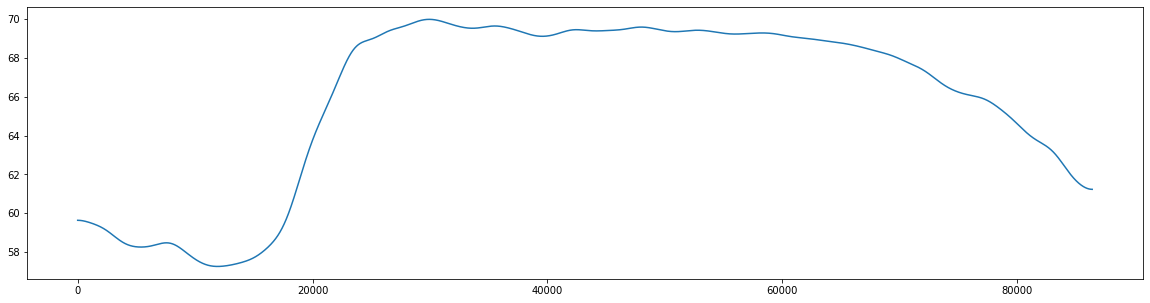

In [1560]:
plt.figure(figsize=(20,5))
# plt.plot(spl_complete_month_weekdays)
#plt.plot(scipy.ndimage.convolve(weekday_medians, np.ones(1001)/1001))
plt.plot(scipy.ndimage.gaussian_filter1d(weekday_medians, 1000))
plt.show()

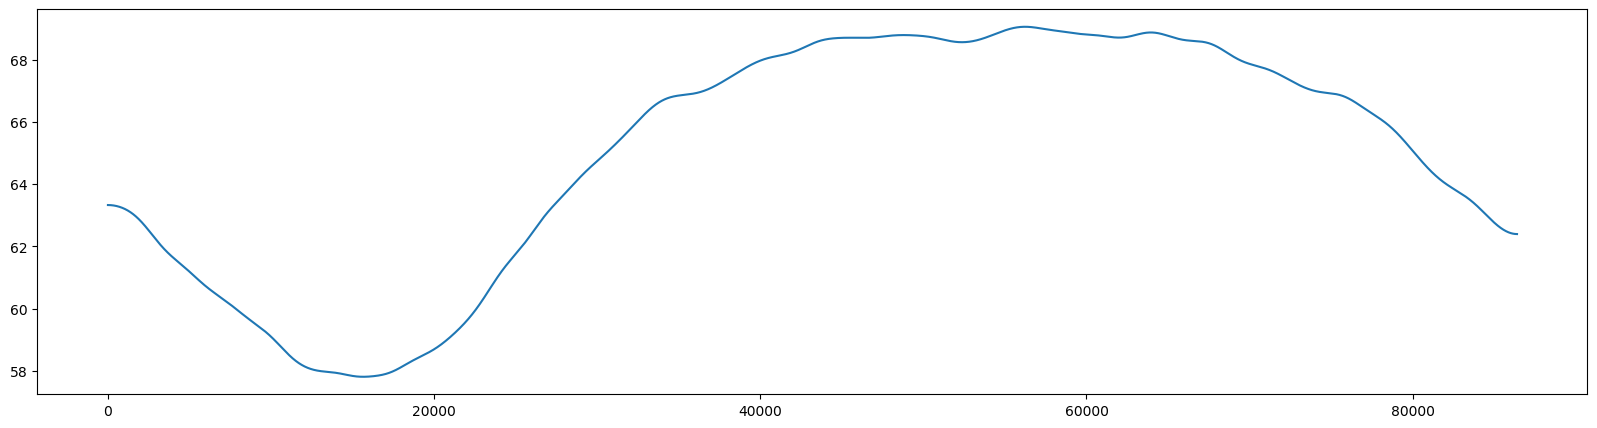

In [2163]:
plt.figure(figsize=(20,5))
# plt.plot(spl_complete_month_weekdays)
#plt.plot(scipy.ndimage.convolve(weekday_medians, np.ones(1001)/1001))
plt.plot(scipy.ndimage.gaussian_filter1d(weekend_medians, 1000))
plt.show()

# Creating dataframe with medians for whole month

In [1588]:
beginning_spl_indices_series = pd.Series(data=beginning_spl_indices)

In [1593]:
weekly_medians_df_index = pd.concat([beginning_spl_indices_series[0:42], all_joined_df.reset_index()['index']])

In [1621]:
month_weekly_median = np.empty(len(weekly_medians_df_index))

In [1623]:
for i in range(len(weekly_medians_df_index)):
    month_weekly_median[i] = weekday_medians[i%len(weekday_medians)]

In [2296]:
month_weekly_median

array([57.755, 58.22 , 57.98 , ..., 62.44 , 60.525, 62.255])

In [2297]:
weekday_medians_df = pd.DataFrame({'median_dBAS':month_weekly_median}, index=weekly_medians_df_index)

In [2298]:
weekday_medians_df.tail()

,median_dBAS
2019-07-01 00:00:38-04:00,61.100
2019-07-01 00:00:39-04:00,61.420
2019-07-01 00:00:40-04:00,62.440
2019-07-01 00:00:41-04:00,60.525
2019-07-01 00:00:42-04:00,62.255


In [1831]:
# plt.figure(figsize=(20,5))
# # plt.plot(spl_complete_month_weekdays)
# #plt.plot(scipy.ndimage.convolve(weekday_medians, np.ones(1001)/1001))
# plt.plot(weekday_medians_df.reset_index()['index'], \
#          scipy.ndimage.gaussian_filter1d(weekday_medians_df['median_dBAS'], 1000))
# plt.show()

# Adding weekend medians to dataframe

In [2165]:
len(weekend_medians)

86400

In [2219]:
len(month_weekly_median)

2589942

In [2221]:
weekend_medians_df_values = np.asarray(weekday_medians_df.loc[weekday_medians_df.index.dayofweek>=5]['median_dBAS'])

In [2226]:
weekday_medians_df.loc[weekday_medians_df.index.dayofweek>=5].index

DatetimeIndex(['2019-06-01 00:00:00-04:00', '2019-06-01 00:00:01-04:00',
               '2019-06-01 00:00:02-04:00', '2019-06-01 00:00:03-04:00',
               '2019-06-01 00:00:04-04:00', '2019-06-01 00:00:05-04:00',
               '2019-06-01 00:00:06-04:00', '2019-06-01 00:00:07-04:00',
               '2019-06-01 00:00:08-04:00', '2019-06-01 00:00:09-04:00',
               ...
               '2019-06-30 23:59:50-04:00', '2019-06-30 23:59:51-04:00',
               '2019-06-30 23:59:52-04:00', '2019-06-30 23:59:53-04:00',
               '2019-06-30 23:59:54-04:00', '2019-06-30 23:59:55-04:00',
               '2019-06-30 23:59:56-04:00', '2019-06-30 23:59:57-04:00',
               '2019-06-30 23:59:58-04:00', '2019-06-30 23:59:59-04:00'],
              dtype='datetime64[ns, US/Eastern]', length=863277, freq=None)

In [2222]:
type(weekend_medians_df_values)

numpy.ndarray

In [2213]:
len(weekend_medians)

86400

In [2223]:
for x in range(len(weekend_medians_df_values)):
    weekend_medians_df_values[x] = weekend_medians[x % len(weekend_medians)]

In [2295]:
weekend_medians_df_values

array([61.01, 63.16, 64.48, ..., 59.41, 58.84, 58.08])

In [2227]:
weekend_medians_df_indices = weekday_medians_df.loc[weekday_medians_df.index.dayofweek>=5].index

In [2228]:
weekend_medians_df = pd.DataFrame({'median_dBAS':weekend_medians_df_values}, index=weekend_medians_df_indices)

In [2263]:
weekend_medians_df = weekend_medians_df[~weekend_medians_df.index.duplicated()]

In [2270]:
weekend_medians_df.tail()

,median_dBAS
2019-06-30 23:59:55-04:00,58.480
2019-06-30 23:59:56-04:00,59.075
2019-06-30 23:59:57-04:00,59.410
2019-06-30 23:59:58-04:00,58.840
2019-06-30 23:59:59-04:00,58.080


# Replacing weekend values in dataframe with correct values

In [2292]:
len(weekday_medians_df)

2589942

In [2271]:
len(weekend_medians_df)

863138

In [2299]:
weekday_medians_df.head()

,median_dBAS
2019-06-01 00:00:00-04:00,57.755
2019-06-01 00:00:01-04:00,58.220
2019-06-01 00:00:02-04:00,57.980
2019-06-01 00:00:03-04:00,58.360
2019-06-01 00:00:04-04:00,58.730


In [2294]:
weekend_medians_df.head()

,median_dBAS
2019-06-01 00:00:00-04:00,61.01
2019-06-01 00:00:01-04:00,63.16
2019-06-01 00:00:02-04:00,64.48
2019-06-01 00:00:03-04:00,63.70
2019-06-01 00:00:04-04:00,63.76


In [2300]:
both_medians_df = weekday_medians_df.merge(weekend_medians_df, how='outer', left_index=True, right_index=True)

In [2301]:
both_medians_df.head()

,median_dBAS_x,median_dBAS_y
2019-06-01 00:00:00-04:00,57.755,61.01
2019-06-01 00:00:01-04:00,58.220,63.16
2019-06-01 00:00:02-04:00,57.980,64.48
2019-06-01 00:00:03-04:00,58.360,63.70
2019-06-01 00:00:04-04:00,58.730,63.76


In [2302]:
both_medians_df['median_dBAS'] = \
both_medians_df['median_dBAS_x'].where(both_medians_df['median_dBAS_y'].isnull(), \
                                                                              both_medians_df['median_dBAS_y'])

In [2305]:
both_medians_df.loc['2019-06-28 23:00:33-04:00']

median_dBAS_x    67.365
median_dBAS_y       NaN
median_dBAS      67.365
Name: 2019-06-28 23:00:33-04:00, dtype: float64

In [2309]:
both_medians_df = both_medians_df.drop(['median_dBAS_x', 'median_dBAS_y'], axis=1)

In [2310]:
both_medians_df.head()

,median_dBAS
2019-06-01 00:00:00-04:00,61.01
2019-06-01 00:00:01-04:00,63.16
2019-06-01 00:00:02-04:00,64.48
2019-06-01 00:00:03-04:00,63.70
2019-06-01 00:00:04-04:00,63.76


# Joining weekday and weekend medians to dataframe

In [2311]:
all_joined_df_cut_median = all_joined_df_cut.join(both_medians_df)

In [ ]:
# all_joined_df_cut_median.loc[all_joined_df_cut_median.index.duplicated()]

In [2312]:
all_joined_df_cut_median.loc['2019-06-29 23:00:33-04:00']

,dBAS,assignment,median_dBAS
2019-06-29 23:00:33-04:00,65.27,2.0,61.59
2019-06-29 23:00:33-04:00,65.27,2.0,61.59
2019-06-29 23:00:33-04:00,71.26,2.0,61.59
2019-06-29 23:00:33-04:00,71.26,2.0,61.59


In [2313]:
removed_all_joined_df_cut_median = all_joined_df_cut_median[~all_joined_df_cut_median.index.duplicated()]

In [2315]:
removed_all_joined_df_cut_median.tail()

,dBAS,assignment,median_dBAS
2019-06-30 23:59:56-04:00,60.74,0.0,59.075
2019-06-30 23:59:57-04:00,59.08,0.0,59.410
2019-06-30 23:59:58-04:00,58.32,0.0,58.840
2019-06-30 23:59:59-04:00,59.30,0.0,58.080
2019-07-01 00:00:00-04:00,59.43,0.0,58.385


In [2316]:
removed_all_joined_df_cut_median['median_dBAS'].values

array([67.14 , 65.64 , 65.555, ..., 58.84 , 58.08 , 58.385])

In [1966]:
scipy.signal.medfilt(removed_all_joined_df_cut_median['median_dBAS'].values, 3)[::1]

array([57.845, 58.08 , 58.09 , ..., 60.305, 60.065, 58.385])

In [1979]:
scipy.ndimage.filters.gaussian_filter(removed_all_joined_df_cut_median['median_dBAS'].values, \
                                                                10)[::2]

array([59.67065542, 59.72163793, 59.83615712, ..., 62.2270668 ,
       62.07410861, 62.00539321])

In [1943]:
font = {'family' : 'normal',
        'size'   : 18}

# matplotlib.rc('font', **font)
matplotlib.rcdefaults()

In [1671]:
def plot_truck_clusters_scatter_median(joined_df_median, peak_window_size, \
                                       smoothing_window_size, smoothing_window_size_median, ds_factor, smoothing):
    """
    Plots the SPL over time with visual cues indicating the presence of trucks over time for one sensor.
    
    Parameters
    ----------
    joined_df : dataframe
        A dataframe containing timestamps, a column for cluster assignments, and dBAS values.
    
    peak_window_size : int
        Parameter for peak picking
        
    ds_factor : int
        Downsample factor for getting the median
    """
    y_vals = []
    joined_df_reset_index = joined_df_median.reset_index()
#     sliced_trucks_df = sliced_joined_df.loc[sliced_joined_df['assignment']==1]
#     sliced_other_df = sliced_joined_df.loc[sliced_joined_df['assignment']==2]
    
    #maybe make a mask for the max SPL that takes timestamps for peaks, then apply it to truck clusters?
    #Peaks for all SPL values
    window = int((peak_window_size-1)/2)
    spl_peaks = librosa.util.peak_pick(joined_df_median['dBAS'], window, window, window, window, 3, 0)
#     print('number of spl peaks: ' + str(len(sliced_spl_peaks)))
    spl_peaks_arr = joined_df_reset_index.loc[spl_peaks]
    dBAS_peaks = joined_df_median['dBAS'][spl_peaks]
    timestamp_peaks = joined_df_reset_index['index'][spl_peaks]
#     sliced_assignment_peaks = sliced_joined_df['assignment'][sliced_spl_peaks]
#     print(sliced_spl_peaks_arr)
    #Peaks for SPL values corresponding to trucks
#     sliced_truck_spl_peaks = librosa.util.peak_pick(sliced_trucks_df['dBAS'], \
#                                                     window, window, window, window, window, 0)
#     print('number of truck peaks: ' + str(len(sliced_truck_spl_peaks)))
#     sliced_truck_spl_peaks = sliced_spl_peaks_arr.loc[sliced_spl_peaks_arr['assignment']==1]
#     print('truck_spl_peaks: ')
#     print(sliced_truck_spl_peaks)
#     sliced_trucks_df_reset_index = sliced_trucks_df.reset_index()
   
    truck_timestamp_peaks = spl_peaks_arr['index'].loc[spl_peaks_arr['assignment']==1]
    print(truck_timestamp_peaks)
    truck_dBAS_peaks = spl_peaks_arr['dBAS'].loc[spl_peaks_arr['assignment']==1]
    print(truck_dBAS_peaks)
    
    
    #Peaks for SPL values corresponding to other clusters
#     sliced_other_spl_peaks = librosa.util.peak_pick(sliced_other_df['dBAS'], \
#                                                     window, window, window, window, window, 0)
    other_dBAS_peaks = spl_peaks_arr.loc[spl_peaks_arr['assignment']==2]['dBAS']
#     print(sliced_other_dBAS_peaks)
#     sliced_other_df_reset_index = sliced_other_df.reset_index()
    other_timestamp_peaks = spl_peaks_arr.loc[spl_peaks_arr['assignment']==2]['index']
    
    fig, ax1 = plt.subplots()  
    color = 'b'
    
    ax1.set_xlabel('time')
    ax1.set_ylabel('SPL', color=color)
        
    #Plot all SPL peaks
#     ax1.scatter(sliced_timestamp_peaks, sliced_dBAS_peaks, color='b', alpha=0.7)
    #Plot dot over max SPL value when that value corresponds to a trucking instance
    ax1.scatter(truck_timestamp_peaks, truck_dBAS_peaks, color='r', s=20)
    ax1.tick_params(axis='y', labelcolor=color)
    
    #Plot SPL peaks corresponding to other clusters
    ax1.scatter(other_timestamp_peaks, other_dBAS_peaks, color='tab:gray', s=20)
#     ax1.plot(sliced_joined_df_reset_index['index'], sliced_joined_df['dBAS'])
    ax1.set_xlim([joined_df_reset_index['index'].iloc[0], joined_df_reset_index['index'].iloc[-1]])
    
    if smoothing == 'median':
        medfit = scipy.signal.medfilt(joined_df_median['dBAS'].values, smoothing_window_size)[::ds_factor]
        medfit_median = scipy.signal.medfilt(joined_df_median['median_dBAS'].values, \
                                             smoothing_window_size_median)[::ds_factor]
        ax1.plot(joined_df_median.iloc[::ds_factor].reset_index()['index'], medfit, color='g')
        ax1.plot(joined_df_median.iloc[::ds_factor].reset_index()['index'], medfit_median, color='b')
        max_y = medfit
    elif smoothing == 'mean':
        mean_filter = scipy.ndimage.convolve(joined_df_median['dBAS'].values, 
                                             np.ones(smoothing_window_size) / smoothing_window_size)[::ds_factor]
        mean_filter_median = scipy.ndimage.convolve(joined_df_median['median_dBAS'].values, \
                                                    np.ones(smoothing_window_size_median) / smoothing_window_size_median)[::ds_factor]
        ax1.plot(joined_df_median.iloc[::ds_factor].reset_index()['index'], mean_filter, color='g')
        ax1.plot(joined_df_median.iloc[::ds_factor].reset_index()['index'], mean_filter_median, color='b')
        max_y = mean_filter        
    elif smoothing == 'gaussian':
        gaussian_filter = scipy.ndimage.filters.gaussian_filter(joined_df_median['dBAS'].values, \
                                                                smoothing_window_size)[::ds_factor]
        gaussian_filter_median = scipy.ndimage.filters.gaussian_filter(joined_df_median['median_dBAS'].values, \
                                                                smoothing_window_size_median)[::ds_factor]
        ax1.plot(joined_df_median.iloc[::ds_factor].reset_index()['index'], gaussian_filter, color='g')
        ax1.plot(joined_df_median.iloc[::ds_factor].reset_index()['index'], gaussian_filter_median, color='b')
        max_y = gaussian_filter
    else:
        raise Exception('Unknown smoothing type')
    
    print(len(joined_df_median.iloc[::ds_factor]))
    #Plot regions corresponding to trucks
    ax1.fill_between(x=joined_df_median.iloc[::ds_factor].reset_index()['index'], \
                     y1=len(joined_df_median.iloc[::ds_factor]['dBAS'])*[joined_df_median['dBAS'].min()], \
                     y2=max_y, \
                     where=joined_df_median.iloc[::ds_factor]['assignment']==1, \
                     color='r', alpha=0.5)
    
    #Plot regions corresponding to other clusters
    ax1.fill_between(x=joined_df_median.iloc[::ds_factor].reset_index()['index'], \
                     y1=len(joined_df_median.iloc[::ds_factor]['dBAS'])*[joined_df_median['dBAS'].min()], \
                     y2=max_y, where=joined_df_median.iloc[::ds_factor]['assignment']==2, \
                     color='tab:gray', alpha=0.5)
    
    ax1.set_ylim(joined_df_median['dBAS'].min())
    fig.set_size_inches(18.5, 10.5)
    fig.tight_layout()
    fig.show()

In [1756]:
# plot_truck_clusters_scatter_median(all_joined_df_cut_median['2019-06-03 14:40:00-04:00':'2019-06-03 14:50:00-04:00'], \
#                             7, 0.5, 10, 1, 'gaussian')

In [1835]:
def plot_truck_clusters_scatter_median_shading(joined_df_median, peak_window_size, \
                                       smoothing_window_size, smoothing_window_size_median, ds_factor, smoothing):
    """
    Plots the SPL over time with visual cues indicating the presence of trucks over time for one sensor.
    
    Parameters
    ----------
    joined_df : dataframe
        A dataframe containing timestamps, a column for cluster assignments, and dBAS values.
    
    peak_window_size : int
        Parameter for peak picking
        
    ds_factor : int
        Downsample factor for getting the median
    """
    y_vals = []
    joined_df_reset_index = joined_df_median.reset_index()
#     sliced_trucks_df = sliced_joined_df.loc[sliced_joined_df['assignment']==1]
#     sliced_other_df = sliced_joined_df.loc[sliced_joined_df['assignment']==2]
    
    #maybe make a mask for the max SPL that takes timestamps for peaks, then apply it to truck clusters?
    #Peaks for all SPL values
    window = int((peak_window_size-1)/2)
    spl_peaks = librosa.util.peak_pick(joined_df_median['dBAS'], window, window, window, window, 3, 0)
#     print('number of spl peaks: ' + str(len(sliced_spl_peaks)))
    spl_peaks_arr = joined_df_reset_index.loc[spl_peaks]
    dBAS_peaks = joined_df_median['dBAS'][spl_peaks]
    timestamp_peaks = joined_df_reset_index['index'][spl_peaks]
#     sliced_assignment_peaks = sliced_joined_df['assignment'][sliced_spl_peaks]
#     print(sliced_spl_peaks_arr)
    #Peaks for SPL values corresponding to trucks
#     sliced_truck_spl_peaks = librosa.util.peak_pick(sliced_trucks_df['dBAS'], \
#                                                     window, window, window, window, window, 0)
#     print('number of truck peaks: ' + str(len(sliced_truck_spl_peaks)))
#     sliced_truck_spl_peaks = sliced_spl_peaks_arr.loc[sliced_spl_peaks_arr['assignment']==1]
#     print('truck_spl_peaks: ')
#     print(sliced_truck_spl_peaks)
#     sliced_trucks_df_reset_index = sliced_trucks_df.reset_index()
   
    truck_timestamp_peaks = spl_peaks_arr['index'].loc[spl_peaks_arr['assignment']==1]
    print(truck_timestamp_peaks)
    truck_dBAS_peaks = spl_peaks_arr['dBAS'].loc[spl_peaks_arr['assignment']==1]
    print(truck_dBAS_peaks)
    
    
    #Peaks for SPL values corresponding to other clusters
#     sliced_other_spl_peaks = librosa.util.peak_pick(sliced_other_df['dBAS'], \
#                                                     window, window, window, window, window, 0)
    other_dBAS_peaks = spl_peaks_arr.loc[spl_peaks_arr['assignment']==2]['dBAS']
#     print(sliced_other_dBAS_peaks)
#     sliced_other_df_reset_index = sliced_other_df.reset_index()
    other_timestamp_peaks = spl_peaks_arr.loc[spl_peaks_arr['assignment']==2]['index']
    
    fig, ax1 = plt.subplots()  
    color = 'b'
    
    ax1.set_xlabel('time')
    ax1.set_ylabel('SPL', color=color)
        
    #Plot all SPL peaks
#     ax1.scatter(sliced_timestamp_peaks, sliced_dBAS_peaks, color='b', alpha=0.7)
    #Plot dot over max SPL value when that value corresponds to a trucking instance
    ax1.scatter(truck_timestamp_peaks, truck_dBAS_peaks, color='r', s=20)
    ax1.tick_params(axis='y', labelcolor=color)
    
    #Plot SPL peaks corresponding to other clusters
    ax1.scatter(other_timestamp_peaks, other_dBAS_peaks, color='tab:gray', s=20)
#     ax1.plot(sliced_joined_df_reset_index['index'], sliced_joined_df['dBAS'])
    ax1.set_xlim([joined_df_reset_index['index'].iloc[0], joined_df_reset_index['index'].iloc[-1]])
    
    if smoothing == 'median':
        medfit = scipy.signal.medfilt(joined_df_median['dBAS'].values, smoothing_window_size)[::ds_factor]
        medfit_median = scipy.signal.medfilt(joined_df_median['median_dBAS'].values, \
                                             smoothing_window_size_median)[::ds_factor]
        ax1.plot(joined_df_median.iloc[::ds_factor].reset_index()['index'], medfit, color='g')
        ax1.plot(joined_df_median.iloc[::ds_factor].reset_index()['index'], medfit_median, color='b')
        min_y = medfit_median
        max_y = medfit
    elif smoothing == 'mean':
        mean_filter = scipy.ndimage.convolve(joined_df_median['dBAS'].values, 
                                             np.ones(smoothing_window_size) / smoothing_window_size)[::ds_factor]
        mean_filter_median = scipy.ndimage.convolve(joined_df_median['median_dBAS'].values, \
                                                    np.ones(smoothing_window_size_median) / smoothing_window_size_median)[::ds_factor]
        ax1.plot(joined_df_median.iloc[::ds_factor].reset_index()['index'], mean_filter, color='g')
        ax1.plot(joined_df_median.iloc[::ds_factor].reset_index()['index'], mean_filter_median, color='b')
        min_y = mean_filter_median
        max_y = mean_filter        
    elif smoothing == 'gaussian':
        gaussian_filter = scipy.ndimage.filters.gaussian_filter(joined_df_median['dBAS'].values, \
                                                                smoothing_window_size)[::ds_factor]
        gaussian_filter_median = scipy.ndimage.filters.gaussian_filter(joined_df_median['median_dBAS'].values, \
                                                                smoothing_window_size_median)[::ds_factor]
        ax1.plot(joined_df_median.iloc[::ds_factor].reset_index()['index'], gaussian_filter, color='g')
        ax1.plot(joined_df_median.iloc[::ds_factor].reset_index()['index'], gaussian_filter_median, color='b')
        min_y = gaussian_filter_median
        max_y = gaussian_filter
#         print(len(max_y))
#         print(len(min_y))
    else:
        raise Exception('Unknown smoothing type')
    
    #Plot regions corresponding to trucks
    ax1.fill_between( \
                     x=joined_df_median.iloc[::ds_factor].reset_index()['index'], \
#                      x=joined_df_median.iloc[::ds_factor]['assignment']==1
                     y1=min_y, \
                     y2=max_y, \
                     where=(joined_df_median.iloc[::ds_factor]['assignment']==1) & (max_y>min_y), \
#                      where=max_y>min_y, \
                     color='r', alpha=0.5, interpolate=True)
    
    #Plot regions corresponding to other clusters
    ax1.fill_between(x=joined_df_median.iloc[::ds_factor].reset_index()['index'], \
                     y1=min_y, \
                     y2=max_y, \
                     where=(joined_df_median.iloc[::ds_factor]['assignment']==2) & (max_y>min_y), 
#                      where=max_y>min_y, \
                     color='tab:gray', alpha=0.5, interpolate=True)
    
    ax1.set_ylim(joined_df_median['dBAS'].min())
    fig.set_size_inches(18.5, 10.5)
    fig.tight_layout()
    fig.show()

In [1912]:
# plot_truck_clusters_scatter_median_shading(all_joined_df_cut_median['2019-06-03 14:40:00-04:00':'2019-06-03 14:50:00-04:00'], \
#                             7, 0.5, 10, 2, 'gaussian')

In [2317]:
len(removed_all_joined_df_cut_median)

2589505

In [2535]:
def plot_truck_clusters_scatter_median_final(joined_df_median, peak_window_size, \
                                       smoothing_window_size, smoothing_window_size_ambient, ds_factor, smoothing):
    """
    Plots the SPL over time with visual cues indicating the presence of trucks over time for one sensor.
    
    Parameters
    ----------
    joined_df : dataframe
        A dataframe containing timestamps, a column for cluster assignments, and dBAS values.
    
    peak_window_size : int
        Parameter for peak picking
        
    smoothing_window : float
        Parameter for smoothing the current SPL. Increasing it smoothes the curve more.
        
    smoothing_window_size_ambient : int
        Parameter for smoothing the ambient SPL. Increasing it smoothes the curve more.
        
    ds_factor : int
        Downsample factor for getting the median
        
    'smoothing' : String
        Type of smoothing. Either median, mean, or gaussian.
    """
    y_vals = []
    joined_df_reset_index = joined_df_median.reset_index()
    
    #maybe make a mask for the max SPL that takes timestamps for peaks, then apply it to truck clusters?
    #Peaks for all SPL values
    window = int((peak_window_size-1)/2)
    spl_peaks = librosa.util.peak_pick(joined_df_median['dBAS'], window, window, window, window, 3, 0)
#     print('number of spl peaks: ' + str(len(sliced_spl_peaks)))
    spl_peaks_arr = joined_df_reset_index.loc[spl_peaks]
    dBAS_peaks = joined_df_median['dBAS'][spl_peaks]
    timestamp_peaks = joined_df_reset_index['index'][spl_peaks]

    truck_timestamp_peaks = spl_peaks_arr['index'].loc[spl_peaks_arr['assignment']==1]
    print(truck_timestamp_peaks)
    truck_dBAS_peaks = spl_peaks_arr['dBAS'].loc[spl_peaks_arr['assignment']==1]
    print(truck_dBAS_peaks)
    
    other_dBAS_peaks = spl_peaks_arr.loc[spl_peaks_arr['assignment']==2]['dBAS']
    other_timestamp_peaks = spl_peaks_arr.loc[spl_peaks_arr['assignment']==2]['index']
    
    fig, ax1 = plt.subplots()  
    
    ax1.set_xlabel('Time (Ten Minutes)', fontweight='bold', fontsize=25)
    ax1.set_ylabel('SPL (dB)', fontweight='bold', fontsize=25)
    ax1.set_title('SPL Levels Over Ten Minutes', fontweight='bold', fontsize=30)   
    
    
    #Plot all SPL peaks
#     ax1.scatter(sliced_timestamp_peaks, sliced_dBAS_peaks, color='b', alpha=0.7)
    #Plot dot over max SPL value when that value corresponds to a trucking instance
    ax1.scatter(truck_timestamp_peaks, truck_dBAS_peaks, color='r', s=50)
    ax1.tick_params(labelsize=20)
    
#     #Plot SPL peaks corresponding to other clusters
#     ax1.scatter(other_timestamp_peaks, other_dBAS_peaks, color='tab:gray', s=20)
# #     ax1.plot(sliced_joined_df_reset_index['index'], sliced_joined_df['dBAS'])
    ax1.set_xlim([joined_df_reset_index['index'].iloc[0], joined_df_reset_index['index'].iloc[-1]])
    
    if smoothing == 'median':
        plot_y = scipy.signal.medfilt(joined_df_median['dBAS'].values, smoothing_window_size)[::ds_factor]
        plot_y_median = scipy.signal.medfilt(joined_df_median['median_dBAS'].values, \
                                             smoothing_window_size_ambient)[::ds_factor]
    elif smoothing == 'mean':
        plot_y = scipy.ndimage.convolve(joined_df_median['dBAS'].values, 
                                             np.ones(smoothing_window_size) / smoothing_window_size)[::ds_factor]
        plot_y_median = scipy.ndimage.convolve(joined_df_median['median_dBAS'].values, \
                                                    np.ones(smoothing_window_size_ambient) / smoothing_window_size_ambient)[::ds_factor]
    elif smoothing == 'gaussian':
        plot_y = scipy.ndimage.filters.gaussian_filter(joined_df_median['dBAS'].values, \
                                                                smoothing_window_size)[::ds_factor]
        plot_y_median = scipy.ndimage.filters.gaussian_filter(joined_df_median['median_dBAS'].values, \
                                                                smoothing_window_size_ambient)[::ds_factor]
#         min_y = gaussian_filter_median
#         max_y = gaussian_filter
#         print(len(max_y))
#         print(len(min_y))
    else:
        raise Exception('Unknown smoothing type')
    
    ax1.plot(joined_df_median.iloc[::ds_factor].reset_index()['index'], \
                 plot_y, color='lightgray', linewidth=3)
    ax1.plot(joined_df_median.iloc[::ds_factor].reset_index()['index'], \
                 plot_y_median, color='dimgray', linewidth=3)
    
#     Plot regions corresponding to other clusters
    other_where = (joined_df_median.iloc[::ds_factor]['assignment']==2) & (plot_y > plot_y_median)
    other_where |= np.roll(other_where, 1)
    ax1.fill_between(x=joined_df_median.iloc[::ds_factor].reset_index()['index'], \
                     y1=plot_y_median, \
                     y2=plot_y, \
                     where=other_where, 
#                      where=max_y>min_y, \
                     color='lightblue', interpolate=False)
    
#     print('truck fill index: ' + str(joined_df_median.iloc[::ds_factor].reset_index()['index']))
#     print(joined_df_median.iloc[::ds_factor][joined_df_median['assignment']==1].reset_index()['index'])
#     print(joined_df_median.iloc[::ds_factor][joined_df_median['assignment']==2].reset_index()['index'])
    
    #Plot regions corresponding to trucks
    truck_where = (joined_df_median.iloc[::ds_factor]['assignment']==1) & (plot_y > plot_y_median)
    truck_where |= np.roll(truck_where, 1)
    ax1.fill_between(\
                     x=joined_df_median.iloc[::ds_factor].reset_index()['index'], \
#                      x=joined_df_median.iloc[::ds_factor][joined_df_median['assignment']==1].reset_index()['index'],
                     y1=plot_y_median, \
                     y2=plot_y, \
#                      where=(joined_df_median.iloc[::ds_factor]['assignment']==1) & (max_y>min_y), \
                     where=truck_where, \
                     color='r', interpolate=False)
    
#     ax1.vlines(x=)
    
    #Plot ambient noise region
#     ax1.fill_between(x=joined_df_median.iloc[::ds_factor].reset_index()['index'], \
#                      y1=len(min_y)*[joined_df_median['dBAS'].min()], \
#                      y2=min_y,  
#                      color='lightgray', alpha=0.25, interpolate=True)
    
#     /ax1.set_ylim(65)

    ax1.set_ylim(joined_df_median['median_dBAS'].min())
    fig.set_size_inches(18.5, 10.5)
    fig.tight_layout()
    fig.show()
    
#     plt.savefig('close_look.png')

143    2019-06-03 08:02:23-04:00
1490   2019-06-03 08:24:50-04:00
Name: index, dtype: datetime64[ns, US/Eastern]
143     79.99
1490    84.45
Name: dBAS, dtype: float64


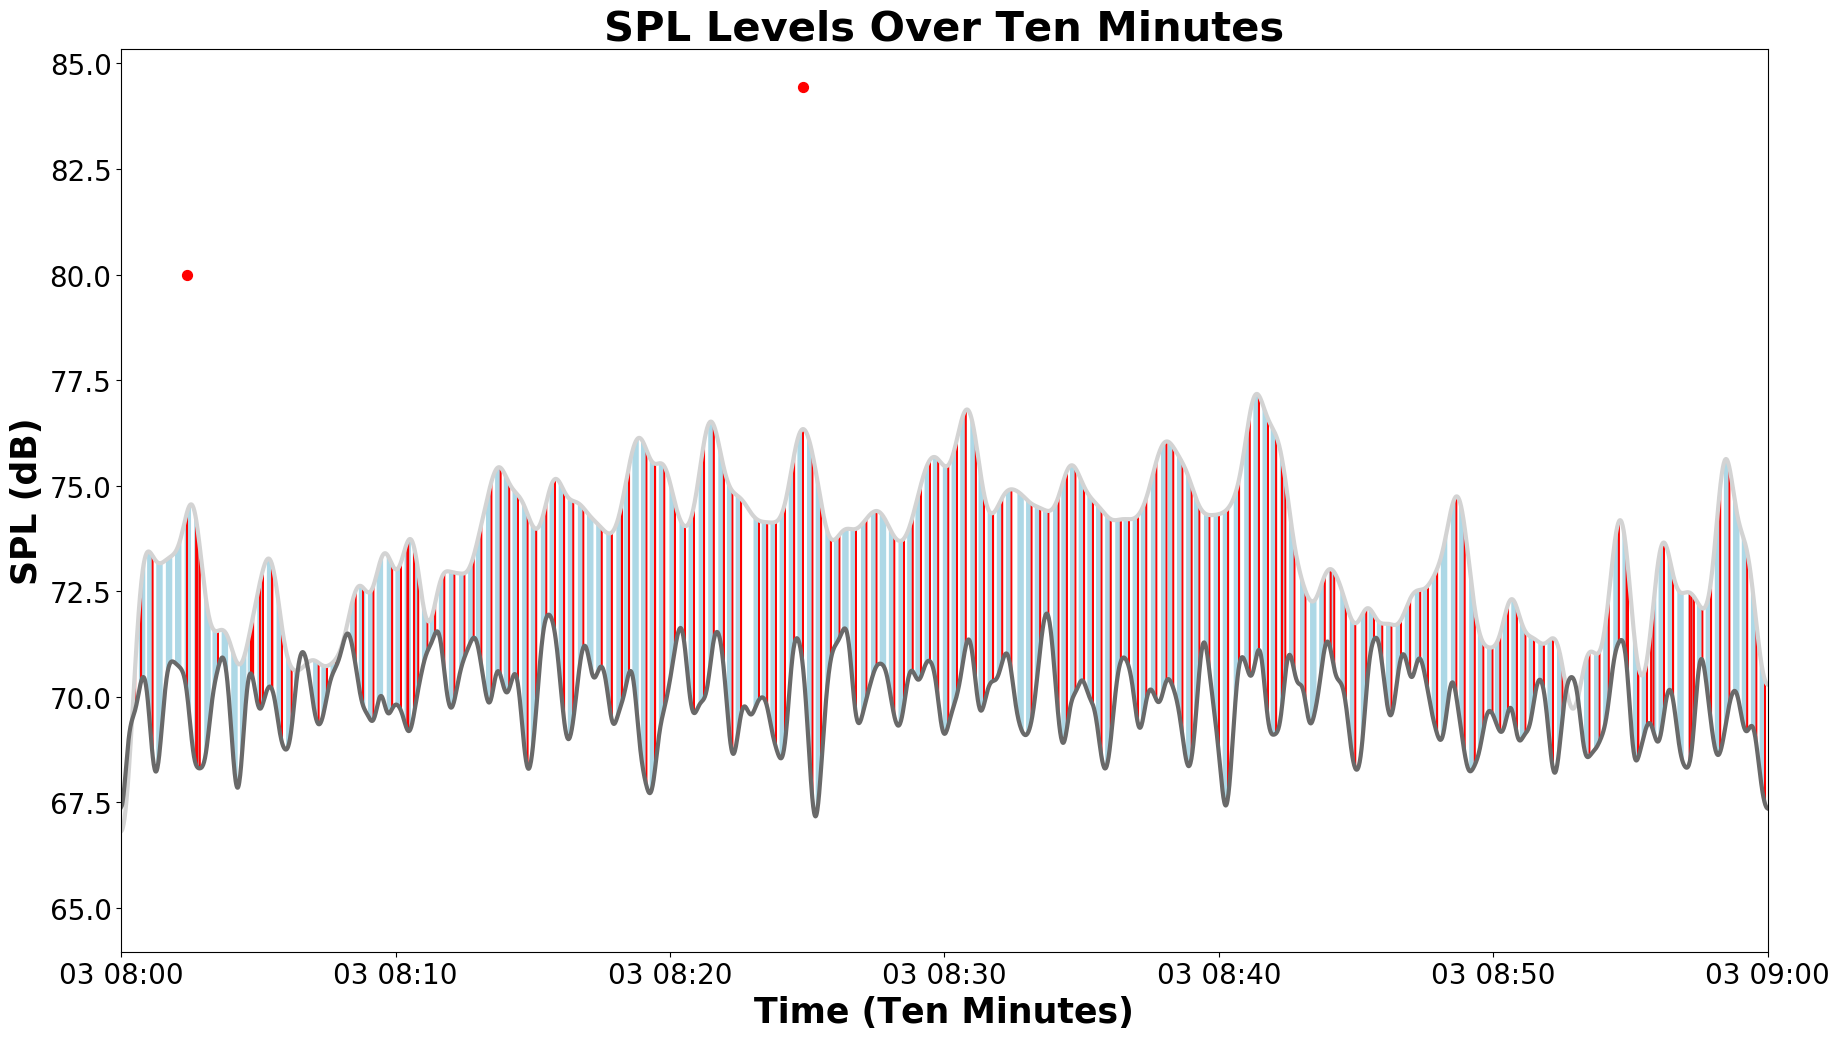

In [2546]:
plot_truck_clusters_scatter_median_final\
(removed_all_joined_df_cut_median['2019-06-03 08:00:00-04:00':'2019-06-03 09:00:00-04:00'], \
                            7, 20, 10, 1, 'gaussian')

In [1863]:
def plot_truck_clusters_scatter_median_normalized(joined_df_median, peak_window_size, \
                                       smoothing_window_size, smoothing_window_size_ambient, ds_factor, smoothing):
    """
    Plots the SPL over time with visual cues indicating the presence of trucks over time for one sensor.
    
    Parameters
    ----------
    joined_df : dataframe
        A dataframe containing timestamps, a column for cluster assignments, and dBAS values.
    
    peak_window_size : int
        Parameter for peak picking
        
    ds_factor : int
        Downsample factor for getting the median
    """
    y_vals = []
    joined_df_reset_index = joined_df_median.reset_index()
    
    joined_df_difference = joined_df_median['dBAS'] - joined_df_median['median_dBAS']
    for i,x in enumerate(joined_df_difference):
        if x < 0:
            joined_df_difference[i] = 0

#     sliced_trucks_df = sliced_joined_df.loc[sliced_joined_df['assignment']==1]
#     sliced_other_df = sliced_joined_df.loc[sliced_joined_df['assignment']==2]
    
    #maybe make a mask for the max SPL that takes timestamps for peaks, then apply it to truck clusters?
    #Peaks for all SPL values
    window = int((peak_window_size-1)/2)
    spl_peaks = librosa.util.peak_pick(joined_df_median['dBAS'], window, window, window, window, 3, 0)
#     print('number of spl peaks: ' + str(len(sliced_spl_peaks)))
    spl_peaks_arr = joined_df_reset_index.loc[spl_peaks]
    dBAS_peaks = joined_df_median['dBAS'][spl_peaks]
    timestamp_peaks = joined_df_reset_index['index'][spl_peaks]
#     sliced_assignment_peaks = sliced_joined_df['assignment'][sliced_spl_peaks]
#     print(sliced_spl_peaks_arr)
    #Peaks for SPL values corresponding to trucks
#     sliced_truck_spl_peaks = librosa.util.peak_pick(sliced_trucks_df['dBAS'], \
#                                                     window, window, window, window, window, 0)
#     print('number of truck peaks: ' + str(len(sliced_truck_spl_peaks)))
#     sliced_truck_spl_peaks = sliced_spl_peaks_arr.loc[sliced_spl_peaks_arr['assignment']==1]
#     print('truck_spl_peaks: ')
#     print(sliced_truck_spl_peaks)
#     sliced_trucks_df_reset_index = sliced_trucks_df.reset_index()
   
    truck_timestamp_peaks = spl_peaks_arr['index'].loc[spl_peaks_arr['assignment']==1]
    print(truck_timestamp_peaks)
    truck_dBAS_peaks = spl_peaks_arr['dBAS'].loc[spl_peaks_arr['assignment']==1]
    print(truck_dBAS_peaks)
    
    
    #Peaks for SPL values corresponding to other clusters
#     sliced_other_spl_peaks = librosa.util.peak_pick(sliced_other_df['dBAS'], \
#                                                     window, window, window, window, window, 0)
    other_dBAS_peaks = spl_peaks_arr.loc[spl_peaks_arr['assignment']==2]['dBAS']
#     print(sliced_other_dBAS_peaks)
#     sliced_other_df_reset_index = sliced_other_df.reset_index()
    other_timestamp_peaks = spl_peaks_arr.loc[spl_peaks_arr['assignment']==2]['index']
    
    fig, ax1 = plt.subplots()  
    color = 'b'
    
    ax1.set_xlabel('time')
    ax1.set_ylabel('SPL', color=color)
        
    #Plot all SPL peaks
#     ax1.scatter(sliced_timestamp_peaks, sliced_dBAS_peaks, color='b', alpha=0.7)
    ax1.tick_params(axis='y', labelcolor=color)
    
    #Plot SPL peaks corresponding to other clusters
#     ax1.scatter(other_timestamp_peaks, other_dBAS_peaks, color='tab:gray', s=20)
#     ax1.plot(sliced_joined_df_reset_index['index'], sliced_joined_df['dBAS'])
    ax1.set_xlim([joined_df_reset_index['index'].iloc[0], joined_df_reset_index['index'].iloc[-1]])
    
    if smoothing == 'median':
        medfit = scipy.signal.medfilt(joined_df_median['dBAS'].values, smoothing_window_size)[::ds_factor]
        medfit_median = scipy.signal.medfilt(joined_df_median['median_dBAS'].values, \
                                             smoothing_window_size_ambient)[::ds_factor]
        plot_y = medfit - medfit_median
        min_y = medfit_median
        max_y = medfit
    elif smoothing == 'mean':
        mean_filter = scipy.ndimage.convolve(joined_df_median['dBAS'].values, 
                                             np.ones(smoothing_window_size) / smoothing_window_size)[::ds_factor]
        mean_filter_median = scipy.ndimage.convolve(joined_df_median['median_dBAS'].values, \
                                                    np.ones(smoothing_window_size_ambient) / \
                                                    smoothing_window_size_ambient)[::ds_factor]
        plot_y = mean_filter - mean_filter_median
        min_y = mean_filter_median
        max_y = mean_filter        
    elif smoothing == 'gaussian':
        gaussian_filter = scipy.ndimage.filters.gaussian_filter(joined_df_median['dBAS'].values, \
                                                                smoothing_window_size)[::ds_factor]
        gaussian_filter_median = scipy.ndimage.filters.gaussian_filter(joined_df_median['median_dBAS'].values, \
                                                                smoothing_window_size_ambient)[::ds_factor]
        plot_y = gaussian_filter - gaussian_filter_median
        min_y = gaussian_filter_median
        max_y = gaussian_filter
    else:
        raise Exception('Unknown smoothing type')
    for i,x in enumerate(plot_y):
        if x < 0:
            plot_y[i] = 0
            
    #Plot dot over max SPL value when that value corresponds to a trucking instance
    normalized_truck_peaks = joined_df_difference.loc[truck_timestamp_peaks]
    ax1.scatter(truck_timestamp_peaks, normalized_truck_peaks, color='r', s=20)
    
    ax1.plot(joined_df_median.iloc[::ds_factor].reset_index()['index'], plot_y, color='g')
#     ax1.plot(joined_df_median.iloc[::ds_factor].reset_index()['index'], mean_filter_median, color='b')
    
    #Plot regions corresponding to trucks
    ax1.fill_between( \
                     x=joined_df_median.iloc[::ds_factor].reset_index()['index'], \
#                      x=joined_df_median.iloc[::ds_factor]['assignment']==1
                     y1=len(min_y)*[0], \
                     y2=plot_y, \
                     where=(joined_df_median.iloc[::ds_factor]['assignment']==1), \
#                      where=max_y>min_y, \
                     color='r', alpha=0.5, interpolate=True)
    
    #Plot regions corresponding to other clusters
    ax1.fill_between(x=joined_df_median.iloc[::ds_factor].reset_index()['index'], \
                     y1=len(min_y)*[0], \
                     y2=plot_y, \
                     where=(joined_df_median.iloc[::ds_factor]['assignment']==2), 
#                      where=max_y>min_y, \
                     color='tab:gray', alpha=0.5, interpolate=True)
    
    ax1.set_ylim(0)
    fig.set_size_inches(18.5, 10.5)
    fig.tight_layout()
    fig.show()

In [1866]:
# plot_truck_clusters_scatter_median_normalized(all_joined_df_cut_median['2019-06-03 14:40:00-04:00':'2019-06-03 14:50:00-04:00'], \
#                             7, 0.5, 10, 2, 'gaussian')

In [2558]:
def plot_truck_clusters_scatter_median_normalized_final(joined_df_median, peak_window_size, \
                                       smoothing_window_size, smoothing_window_size_median, ds_factor, smoothing):
    """
    Plots the SPL over time with visual cues indicating the presence of trucks over time for one sensor.
    
    Parameters
    ----------
    joined_df : dataframe
        A dataframe containing timestamps, a column for cluster assignments, and dBAS values.
    
    peak_window_size : int
        Parameter for peak picking
        
    ds_factor : int
        Downsample factor for getting the median
    """
    y_vals = []
    joined_df_reset_index = joined_df_median.reset_index()
    
    joined_df_difference = joined_df_median['dBAS'] - joined_df_median['median_dBAS']
#     print('joined_df_difference: ' + str(joined_df_difference))
    for i,x in enumerate(joined_df_difference):
        if x < 0:
            joined_df_difference[i] = 0

    #Peaks for all SPL values
    window = int((peak_window_size-1)/2)
    spl_peaks = librosa.util.peak_pick(joined_df_median['dBAS'], window, window, window, window, 3, 0)
#     print('number of spl peaks: ' + str(len(sliced_spl_peaks)))
    spl_peaks_arr = joined_df_reset_index.loc[spl_peaks]
    dBAS_peaks = joined_df_median['dBAS'][spl_peaks]
    timestamp_peaks = joined_df_reset_index['index'][spl_peaks]
   
    truck_timestamp_peaks = spl_peaks_arr['index'].loc[spl_peaks_arr['assignment']==1]
    truck_dBAS_peaks = spl_peaks_arr['dBAS'].loc[spl_peaks_arr['assignment']==1]
    print(len(truck_timestamp_peaks))
    
    #Peaks for SPL values corresponding to other clusters
#     sliced_other_spl_peaks = librosa.util.peak_pick(sliced_other_df['dBAS'], \
#                                                     window, window, window, window, window, 0)
    other_dBAS_peaks = spl_peaks_arr.loc[spl_peaks_arr['assignment']==2]['dBAS']
#     print(sliced_other_dBAS_peaks)
#     sliced_other_df_reset_index = sliced_other_df.reset_index()
    other_timestamp_peaks = spl_peaks_arr.loc[spl_peaks_arr['assignment']==2]['index']
    
    fig, ax1 = plt.subplots()  
    
    ax1.set_xlabel('Time (One Month)', fontweight='bold', fontsize=25)
    ax1.set_ylabel('Increase Above Ambient SPL (dB)', fontweight='bold', fontsize=25)
    ax1.set_title('Truck Noise Contribution Over June', fontweight='bold', fontsize=30)
        
    #Plot all SPL peaks
#     ax1.scatter(sliced_timestamp_peaks, sliced_dBAS_peaks, color='b', alpha=0.7)
    ax1.tick_params(labelsize='20')
    
    #Plot SPL peaks corresponding to other clusters
#     ax1.scatter(other_timestamp_peaks, other_dBAS_peaks, color='tab:gray', s=20)
#     ax1.plot(sliced_joined_df_reset_index['index'], sliced_joined_df['dBAS'])
    ax1.set_xlim([joined_df_reset_index['index'].iloc[0], joined_df_reset_index['index'].iloc[-1]])
    
    if smoothing == 'median':
        medfit = scipy.signal.medfilt(joined_df_median['dBAS'].values, smoothing_window_size)[::ds_factor]
        medfit_median = scipy.signal.medfilt(joined_df_median['median_dBAS'].values, \
                                             smoothing_window_size_median)[::ds_factor]
        plot_y = medfit - medfit_median
        min_y = medfit_median
        max_y = medfit
    elif smoothing == 'mean':
        mean_filter = scipy.ndimage.convolve(joined_df_median['dBAS'].values, 
                                             np.ones(smoothing_window_size) / smoothing_window_size)[::ds_factor]
        mean_filter_median = scipy.ndimage.convolve(joined_df_median['median_dBAS'].values, \
                                                    np.ones(smoothing_window_size_median) / \
                                                    smoothing_window_size_median)[::ds_factor]
        plot_y = mean_filter - mean_filter_median
        min_y = mean_filter_median
        max_y = mean_filter        
    elif smoothing == 'gaussian':
        gaussian_filter = scipy.ndimage.filters.gaussian_filter(joined_df_median['dBAS'].values, \
                                                                smoothing_window_size)[::ds_factor]
        gaussian_filter_median = scipy.ndimage.filters.gaussian_filter(joined_df_median['median_dBAS'].values, \
                                                                smoothing_window_size_median)[::ds_factor]
        plot_y = gaussian_filter - gaussian_filter_median
        min_y = gaussian_filter_median
        max_y = gaussian_filter
    else:
        raise Exception('Unknown smoothing type')
    for i,x in enumerate(plot_y):
        if x < 0:
            plot_y[i] = 0
    
    #Plot dot over max SPL value when that value corresponds to a trucking instance
#     normalized_truck_peaks = joined_df_difference.loc[truck_timestamp_peaks]
#     print(truck_timestamp_peaks.shape)
#     print(normalized_truck_peaks.shape)
#     ax1.scatter(truck_timestamp_peaks, normalized_truck_peaks, color='r', s=20)
    
#     ax1.plot(joined_df_median.iloc[::ds_factor].reset_index()['index'], plot_y, color='g')
#     ax1.plot(joined_df_median.iloc[::ds_factor].reset_index()['index'], mean_filter_median, color='b')
    
#     Plot regions corresponding to trucks
    truck_where = (joined_df_median.iloc[::ds_factor]['assignment']==1)
    truck_where |= np.roll(truck_where, 1)
    ax1.fill_between( \
                     x=joined_df_median.iloc[::ds_factor].reset_index()['index'], \
#                      x=joined_df_median.iloc[::ds_factor]['assignment']==1
                     y1=len(min_y)*[0], \
                     y2=plot_y, \
                     where=truck_where, \
#                      where=max_y>min_y, \
                     color='r', alpha=0.5, interpolate=True)
    
#     #Plot regions corresponding to other clusters
#     ax1.fill_between(x=joined_df_median.iloc[::ds_factor].reset_index()['index'], \
#                      y1=len(min_y)*[0], \
#                      y2=plot_y, \
#                      where=(joined_df_median.iloc[::ds_factor]['assignment']==2), 
# #                      where=max_y>min_y, \
#                      color='tab:gray', alpha=0.5, interpolate=True)

    ax1.vlines(joined_df_median.reset_index()['index'][::604800], \
               0, plot_y.max() + 5, color='dimgray')
    ax1.set_ylim(0, plot_y.max())
    fig.set_size_inches(18.5, 10.5)
    fig.tight_layout()
    fig.show()
    
    plt.savefig('normalized.png')

In [2032]:
# plot_truck_clusters_scatter_median_normalized_final\
# (removed_all_joined_df_cut_median['2019-06-03 08:00:00-04:00':'2019-06-03 20:00:00-04:00'], \
#                             7, 1, 10, 2, 'mean')

In [2527]:
# plot_truck_clusters_scatter_median_normalized_final\
# (removed_all_joined_df_cut_median['2019-06-04 00:00:00-04:00':'2019-06-05 00:00:00-04:00'], \
#                             7, 1, 10, 2, 'mean')

In [2528]:
# plot_truck_clusters_scatter_median_normalized_final\
# (removed_all_joined_df_cut_median['2019-06-10 08:00:00-04:00':'2019-06-17 08:00:00-04:00'], \
#                             7, 1, 10, 2, 'mean')

/home/cusp/meh708/.conda/envs/redhook_analysis_storage/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


6267


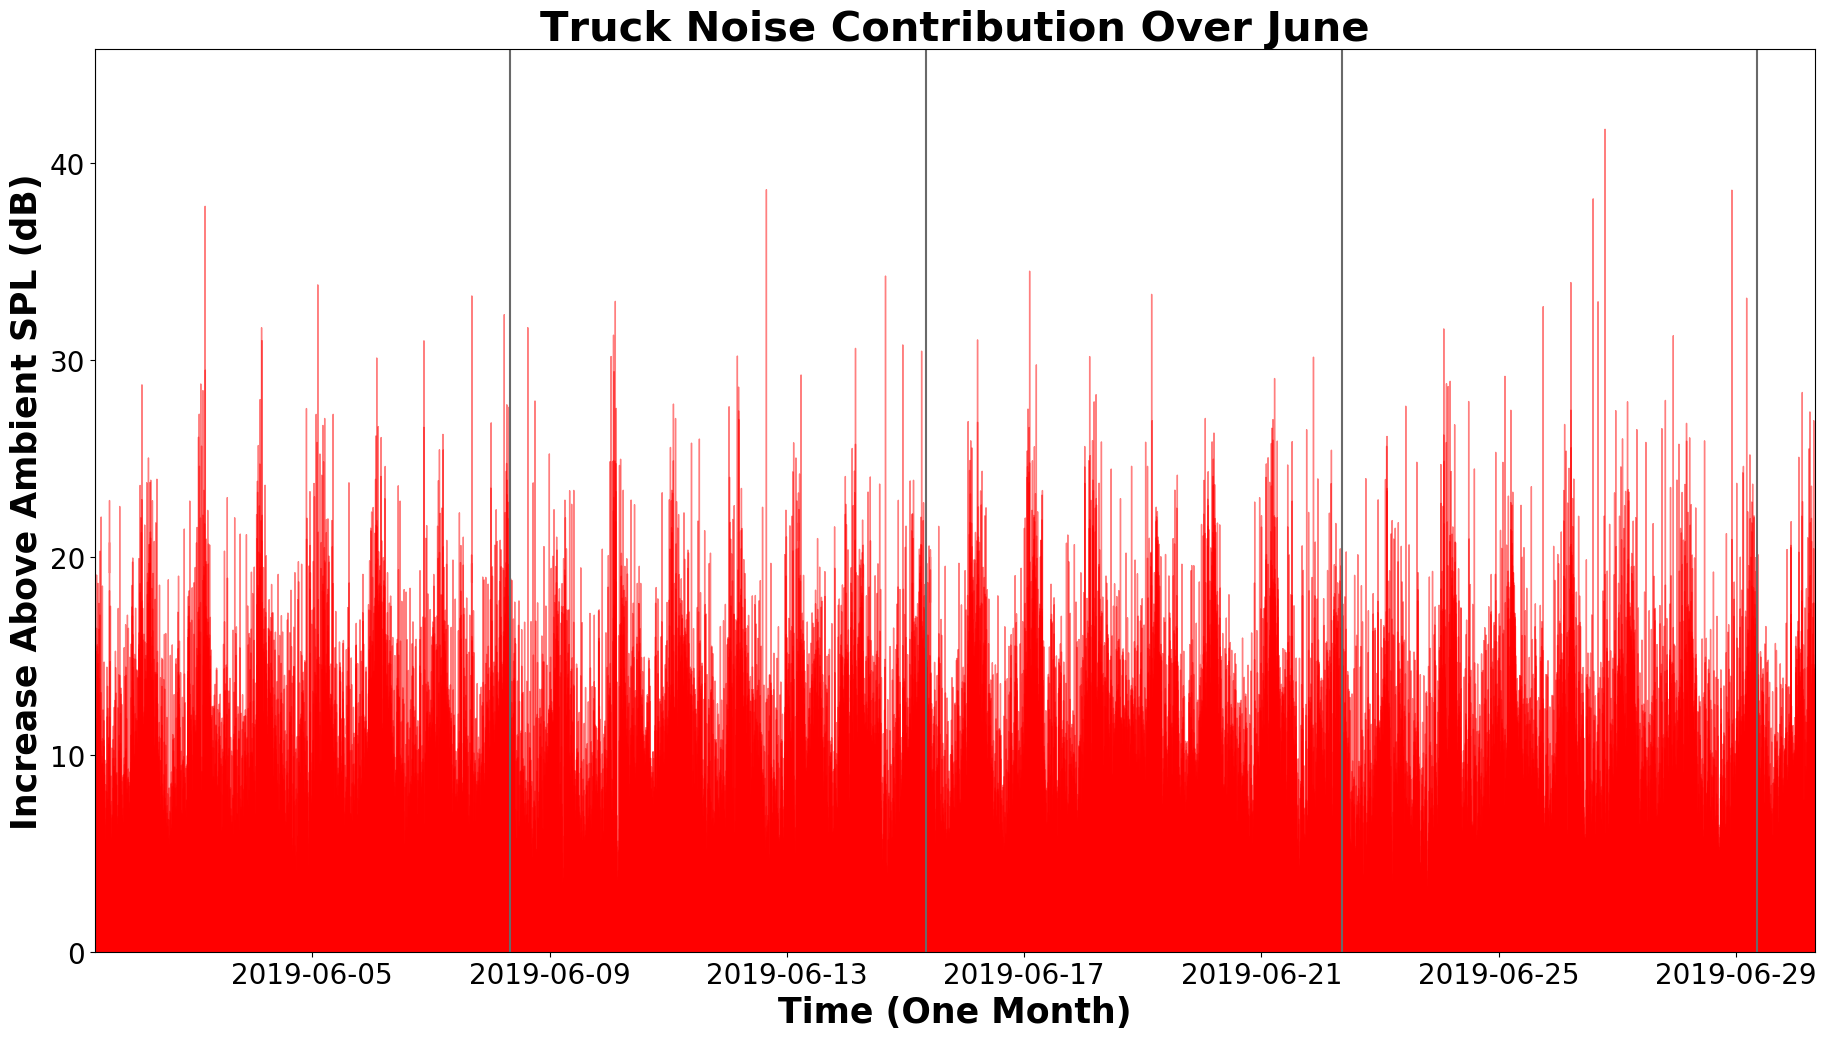

In [2559]:
plot_truck_clusters_scatter_median_normalized_final\
(removed_all_joined_df_cut_median['2019-06-01 08:00:00-04:00':'2019-06-30 08:00:00-04:00'], \
                            7, 1, 10, 2, 'mean')

In [1907]:
# plot_truck_clusters_scatter_median_normalized_final\
# (removed_all_joined_df_cut_median['2019-06-01 08:00:00-04:00':'2019-06-30 08:00:00-04:00'], \
#                             7, 1000, 10, 60, 'mean')

In [2555]:
len(removed_all_joined_df_cut_median.loc[removed_all_joined_df_cut_median['assignment']==1])

348126

In [2556]:
len(removed_all_joined_df_cut_median)

2589505

In [2557]:
348126/2589505

0.13443727662236604